In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
#from skopt import BayesSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from scipy.stats import norm, skew
import sklearn.metrics as metrics
import math
#from skopt.space import Real, Integer


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

plt.rcParams.update({'figure.max_open_warning': 0})
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

In [3]:
df_train = pd.read_csv("train.csv", index_col="Id")
df_test = pd.read_csv("test.csv", index_col="Id")

df = pd.concat([df_train, df_test])

print(df_train.shape)
print(df_test.shape)
print(df.shape)

(1460, 80)
(1459, 79)
(2919, 80)


In [4]:
df.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  2919.000000  2433.000000    2919.000000  2919.000000  2919.000000   
mean     57.137718    69.305795   10168.114080     6.089072     5.564577   
std      42.517628    23.344905    7886.996359     1.409947     1.113131   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7478.000000     5.000000     5.000000   
50%      50.000000    68.000000    9453.000000     6.000000     5.000000   
75%      70.000000    80.000000   11570.000000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  2919.000000   2919.000000  2896.000000  2918.000000  2918.000000   
mean   1971.312778   1984.264474   102.201312   441.423235    49.582248   
std      30.291442     20.894344   179.334253   455.610826   169.205611   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000   
25%    1953.500000   1965.000000     0.000000     0.000000     0.000000   
50%    1973.000000   1993.000000     0.000000   368.500000     0.000000   
75%    2001.000000   2004.000000   164.000000   733.000000     0.000000   
max    2010.000000   2010.000000  1600.000000  5644.000000  1526.000000   

         BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF  \
count  2918.000000  2918.000000  2919.000000  2919.000000   2919.000000   
mean    560.772104  1051.777587  1159.581706   336.483727      4.694416   
std     439.543659   440.766258   392.362079   428.701456     46.396825   
min       0.000000     0.000000   334.000000     0.000000      0.000000   
25%     220.000000   793.000000   876.000000     0.000000      0.000000   
50%     467.000000   989.500000  1082.000000     0.000000      0.000000   
75%     805.500000  1302.000000  1387.500000   704.000000      0.000000   
max    2336.000000  6110.000000  5095.000000  2065.000000   1064.000000   

         GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  \
count  2919.000000   2917.000000   2917.000000  2919.000000  2919.000000   
mean   1500.759849      0.429894      0.061364     1.568003     0.380267   
std     506.051045      0.524736      0.245687     0.552969     0.502872   
min     334.000000      0.000000      0.000000     0.000000     0.000000   
25%    1126.000000      0.000000      0.000000     1.000000     0.000000   
50%    1444.000000      0.000000      0.000000     2.000000     0.000000   
75%    1743.500000      1.000000      0.000000     2.000000     1.000000   
max    5642.000000      3.000000      2.000000     4.000000     2.000000   

       BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt  \
count   2919.000000   2919.000000   2919.000000  2919.000000  2760.000000   
mean       2.860226      1.044536      6.451524     0.597122  1978.113406   
std        0.822693      0.214462      1.569379     0.646129    25.574285   
min        0.000000      0.000000      2.000000     0.000000  1895.000000   
25%        2.000000      1.000000      5.000000     0.000000  1960.000000   
50%        3.000000      1.000000      6.000000     1.000000  1979.000000   
75%        3.000000      1.000000      7.000000     1.000000  2002.000000   
max        8.000000      3.000000     15.000000     4.000000  2207.000000   

        GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count  2918.000000  2918.000000  2919.000000  2919.000000    2919.000000   
mean      1.766621   472.874572    93.709832    47.486811      23.098321   
std       0.761624   215.394815   126.526589    67.575493      64.244246   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       1.000000   320.000000     0.000000     0.000000       0.000000   
50%       2.000000   480.000000     0.000000    26.000000       0.000000   
75%       2.000000   576.000000   168.000000    70.000000   

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [6]:
def missing(df):
    miss = pd.DataFrame({"no_missing_values": df.isnull().sum(),
                         "missing_value_ratio": (df.isnull().sum() / df.shape[0]).round(4),
                         "missing_in_train": df[df.SalePrice.notnull()].isnull().sum(),
                         "missing_in_test": df[df.SalePrice.isnull()].isnull().sum(),
                         })
    return miss[miss.no_missing_values > 0].sort_values("no_missing_values", ascending=False)

missing(df)

no_missing_values  missing_value_ratio  missing_in_train  \
PoolQC                     2909               0.9966              1453   
MiscFeature                2814               0.9640              1406   
Alley                      2721               0.9322              1369   
Fence                      2348               0.8044              1179   
SalePrice                  1459               0.4998                 0   
FireplaceQu                1420               0.4865               690   
LotFrontage                 486               0.1665               259   
GarageCond                  159               0.0545                81   
GarageYrBlt                 159               0.0545                81   
GarageFinish                159               0.0545                81   
GarageQual                  159               0.0545                81   
GarageType                  157               0.0538                81   
BsmtExposure                 82               0.0281                38   
BsmtCond                     82               0.0281                37   
BsmtQual                     81               0.0277                37   
BsmtFinType2                 80               0.0274                38   
BsmtFinType1                 79               0.0271                37   
MasVnrType                   24               0.0082                 8   
MasVnrArea                   23               0.0079                 8   
MSZoning                      4               0.0014                 0   
Functional                    2               0.0007                 0   
BsmtHalfBath                  2               0.0007                 0   
BsmtFullBath                  2               0.0007                 0   
Utilities                     2               0.0007                 0   
KitchenQual                   1               0.0003                 0   
TotalBsmtSF                   1               0.0003                 0   
BsmtUnfSF                     1               0.0003                 0   
GarageCars                    1               0.0003                 0   
GarageArea                    1               0.0003                 0   
BsmtFinSF2                    1               0.0003                 0   
BsmtFinSF1                    1               0.0003                 0   
Exterior2nd                   1               0.0003                 0   
Exterior1st                   1               0.0003                 0   
SaleType                      1               0.0003                 0   
Electrical                    1               0.0003                 1   

              missing_in_test  
PoolQC                   1456  
MiscFeature              1408  
Alley                    1352  
Fence                    1169  
SalePrice                1459  
FireplaceQu               730  
LotFrontage               227  
GarageCond                 78  
GarageYrBlt                78  
GarageFinish               78  
GarageQual                 78  
GarageType                 76  
BsmtExposure               44  
BsmtCond                   45  
BsmtQual                   44  
BsmtFinType2               42  
BsmtFinType1               42  
MasVnrType                 16  
MasVnrArea                 15  
MSZoning                    4  
Functional                  2  
BsmtHalfBath                2  
BsmtFullBath                2  
Utilities                   2  
KitchenQual                 1  
TotalBsmtSF                 1  
BsmtUnfSF                   1  
GarageCars                  1  
GarageArea                  1  
BsmtFinSF2                  1  
BsmtFinSF1                  1  
Exterior2nd                 1  
Exterior1st                 1  
SaleType                    1  
Electrical                  0

In [7]:
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values :  \n",df.nunique())
print ("\nDuplicated values :  \n",df.duplicated().sum())

Rows     :  2919
Columns  :  80

Features : 
 ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPor

In [8]:
#Categorical columns
categorical_cols = [cname for cname in df.columns if  
                   df[cname].dtype == "object"]

#Select numerical columns
numerical_cols = [cname for cname in df.columns if 
                df[cname].dtype in ['int64', 'float64']]

In [9]:
#categorical_cols
for i in range(len(categorical_cols)):
    print("\nFeatures : \n" ,df[categorical_cols[i]].value_counts(0))


Features : 
 RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

Features : 
 Pave    2907
Grvl      12
Name: Street, dtype: int64

Features : 
 Grvl    120
Pave     78
Name: Alley, dtype: int64

Features : 
 Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64

Features : 
 Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64

Features : 
 AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

Features : 
 Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

Features : 
 Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64

Features : 
 NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48

In [10]:
for i in range(len(numerical_cols)):
    print("\nFeatures : \n" ,df[numerical_cols[i]].value_counts(0))


Features : 
 20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

Features : 
 60.0     276
80.0     137
70.0     133
50.0     117
75.0     105
65.0      93
85.0      76
21.0      50
24.0      49
63.0      47
78.0      46
90.0      46
68.0      44
64.0      43
74.0      39
72.0      39
73.0      33
62.0      31
52.0      28
100.0     28
82.0      28
79.0      28
51.0      27
59.0      27
57.0      26
66.0      26
76.0      25
53.0      24
55.0      24
43.0      23
88.0      22
67.0      22
69.0      20
35.0      19
56.0      19
71.0      19
44.0      19
84.0      18
81.0      18
58.0      17
61.0      17
34.0      16
40.0      16
48.0      16
95.0      15
110.0     15
92.0      15
77.0      15
86.0      15
91.0      14
41.0      14
120.0     14
96.0      14
83.0      13
93.0      13
42.0      12
94.0      12
98.0    

<AxesSubplot:>

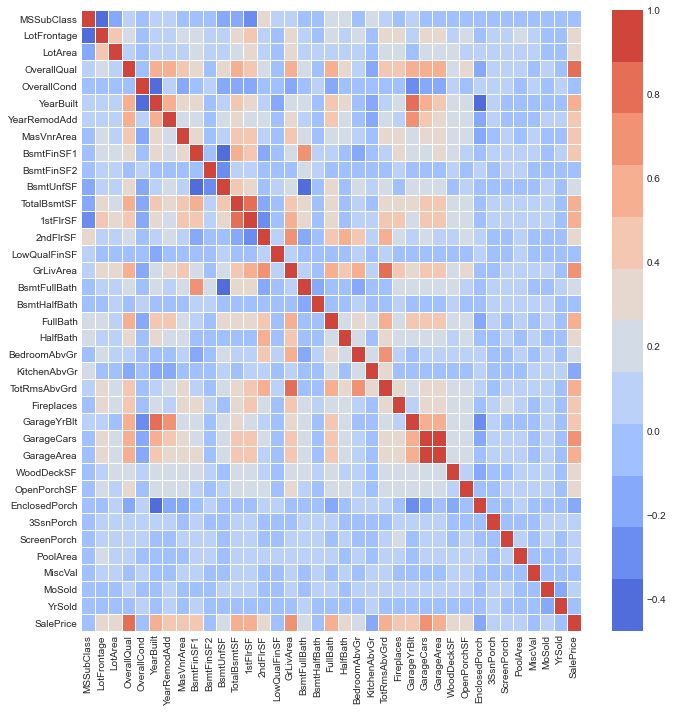

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
colormap = sns.color_palette("coolwarm", 12)#("viridis", as_cmap=True)
sns.heatmap(df.corr(), linewidths=.5, ax=ax, cmap=colormap)

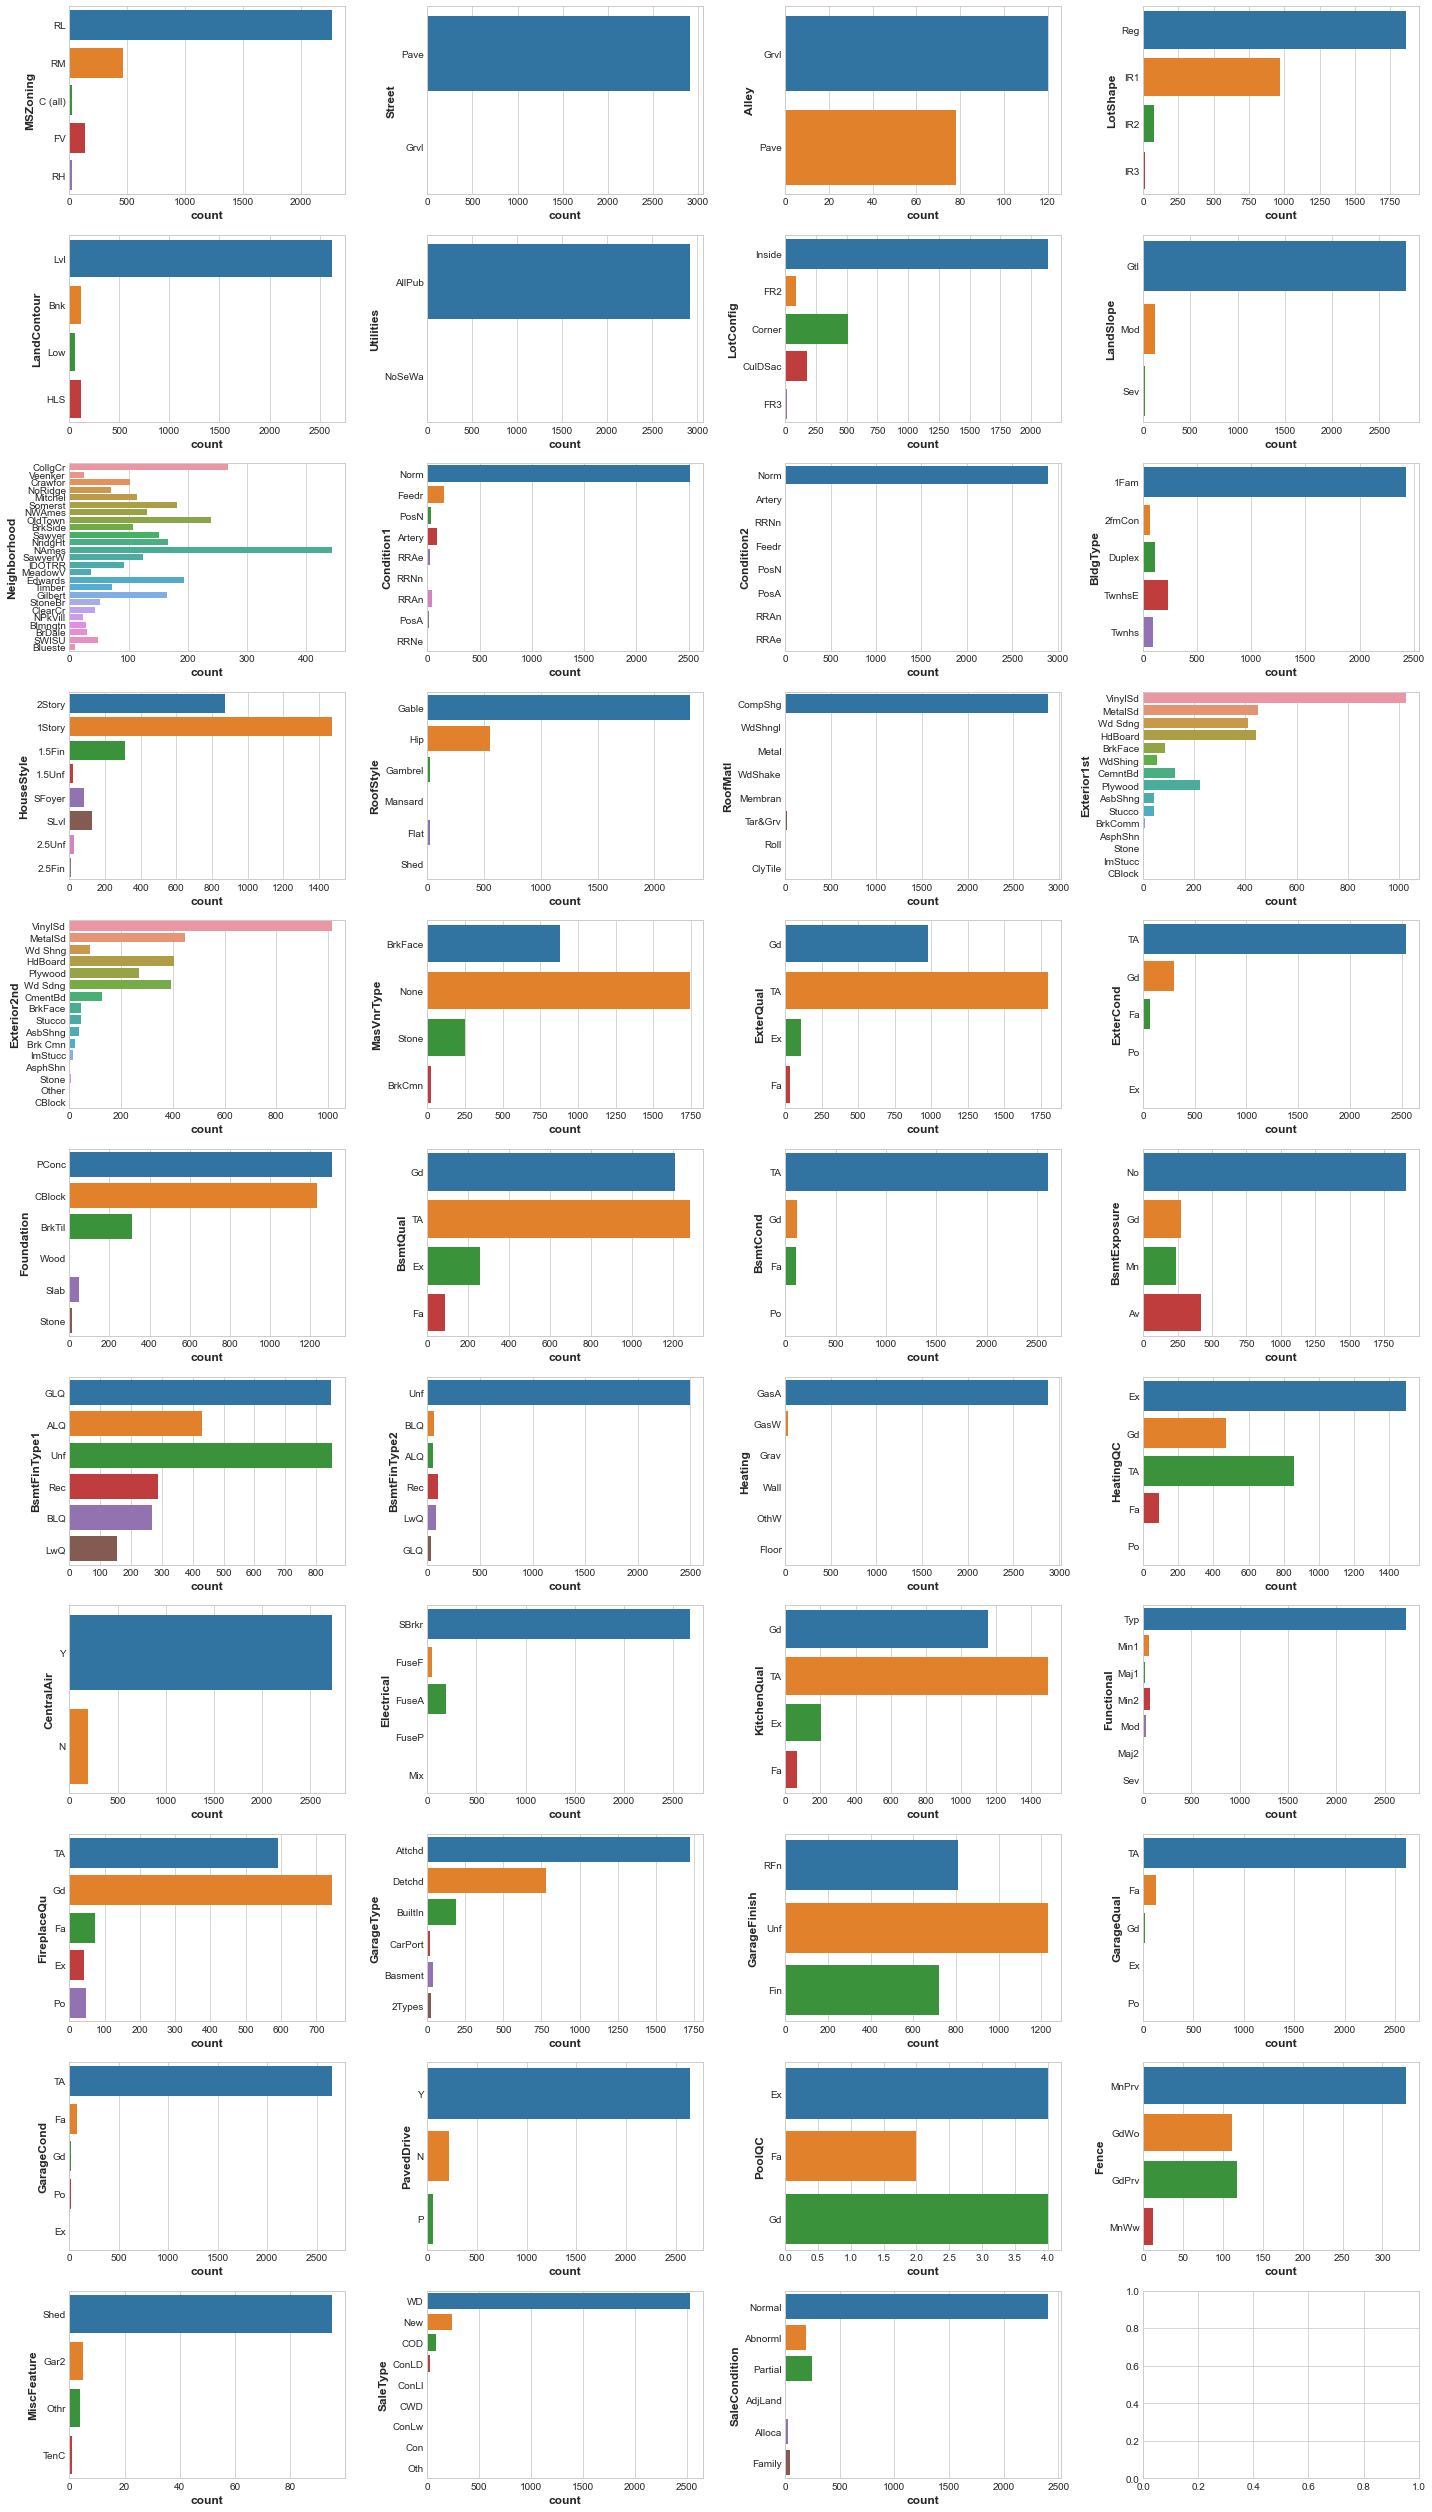

In [12]:
fig, axes = plt.subplots(11, 4, figsize=(20, 35))
fig.tight_layout(pad=8.0)
for i in range(len(categorical_cols)):
    sns.countplot(ax=axes[i//4, i%4], y=df[categorical_cols[i]], data=df)

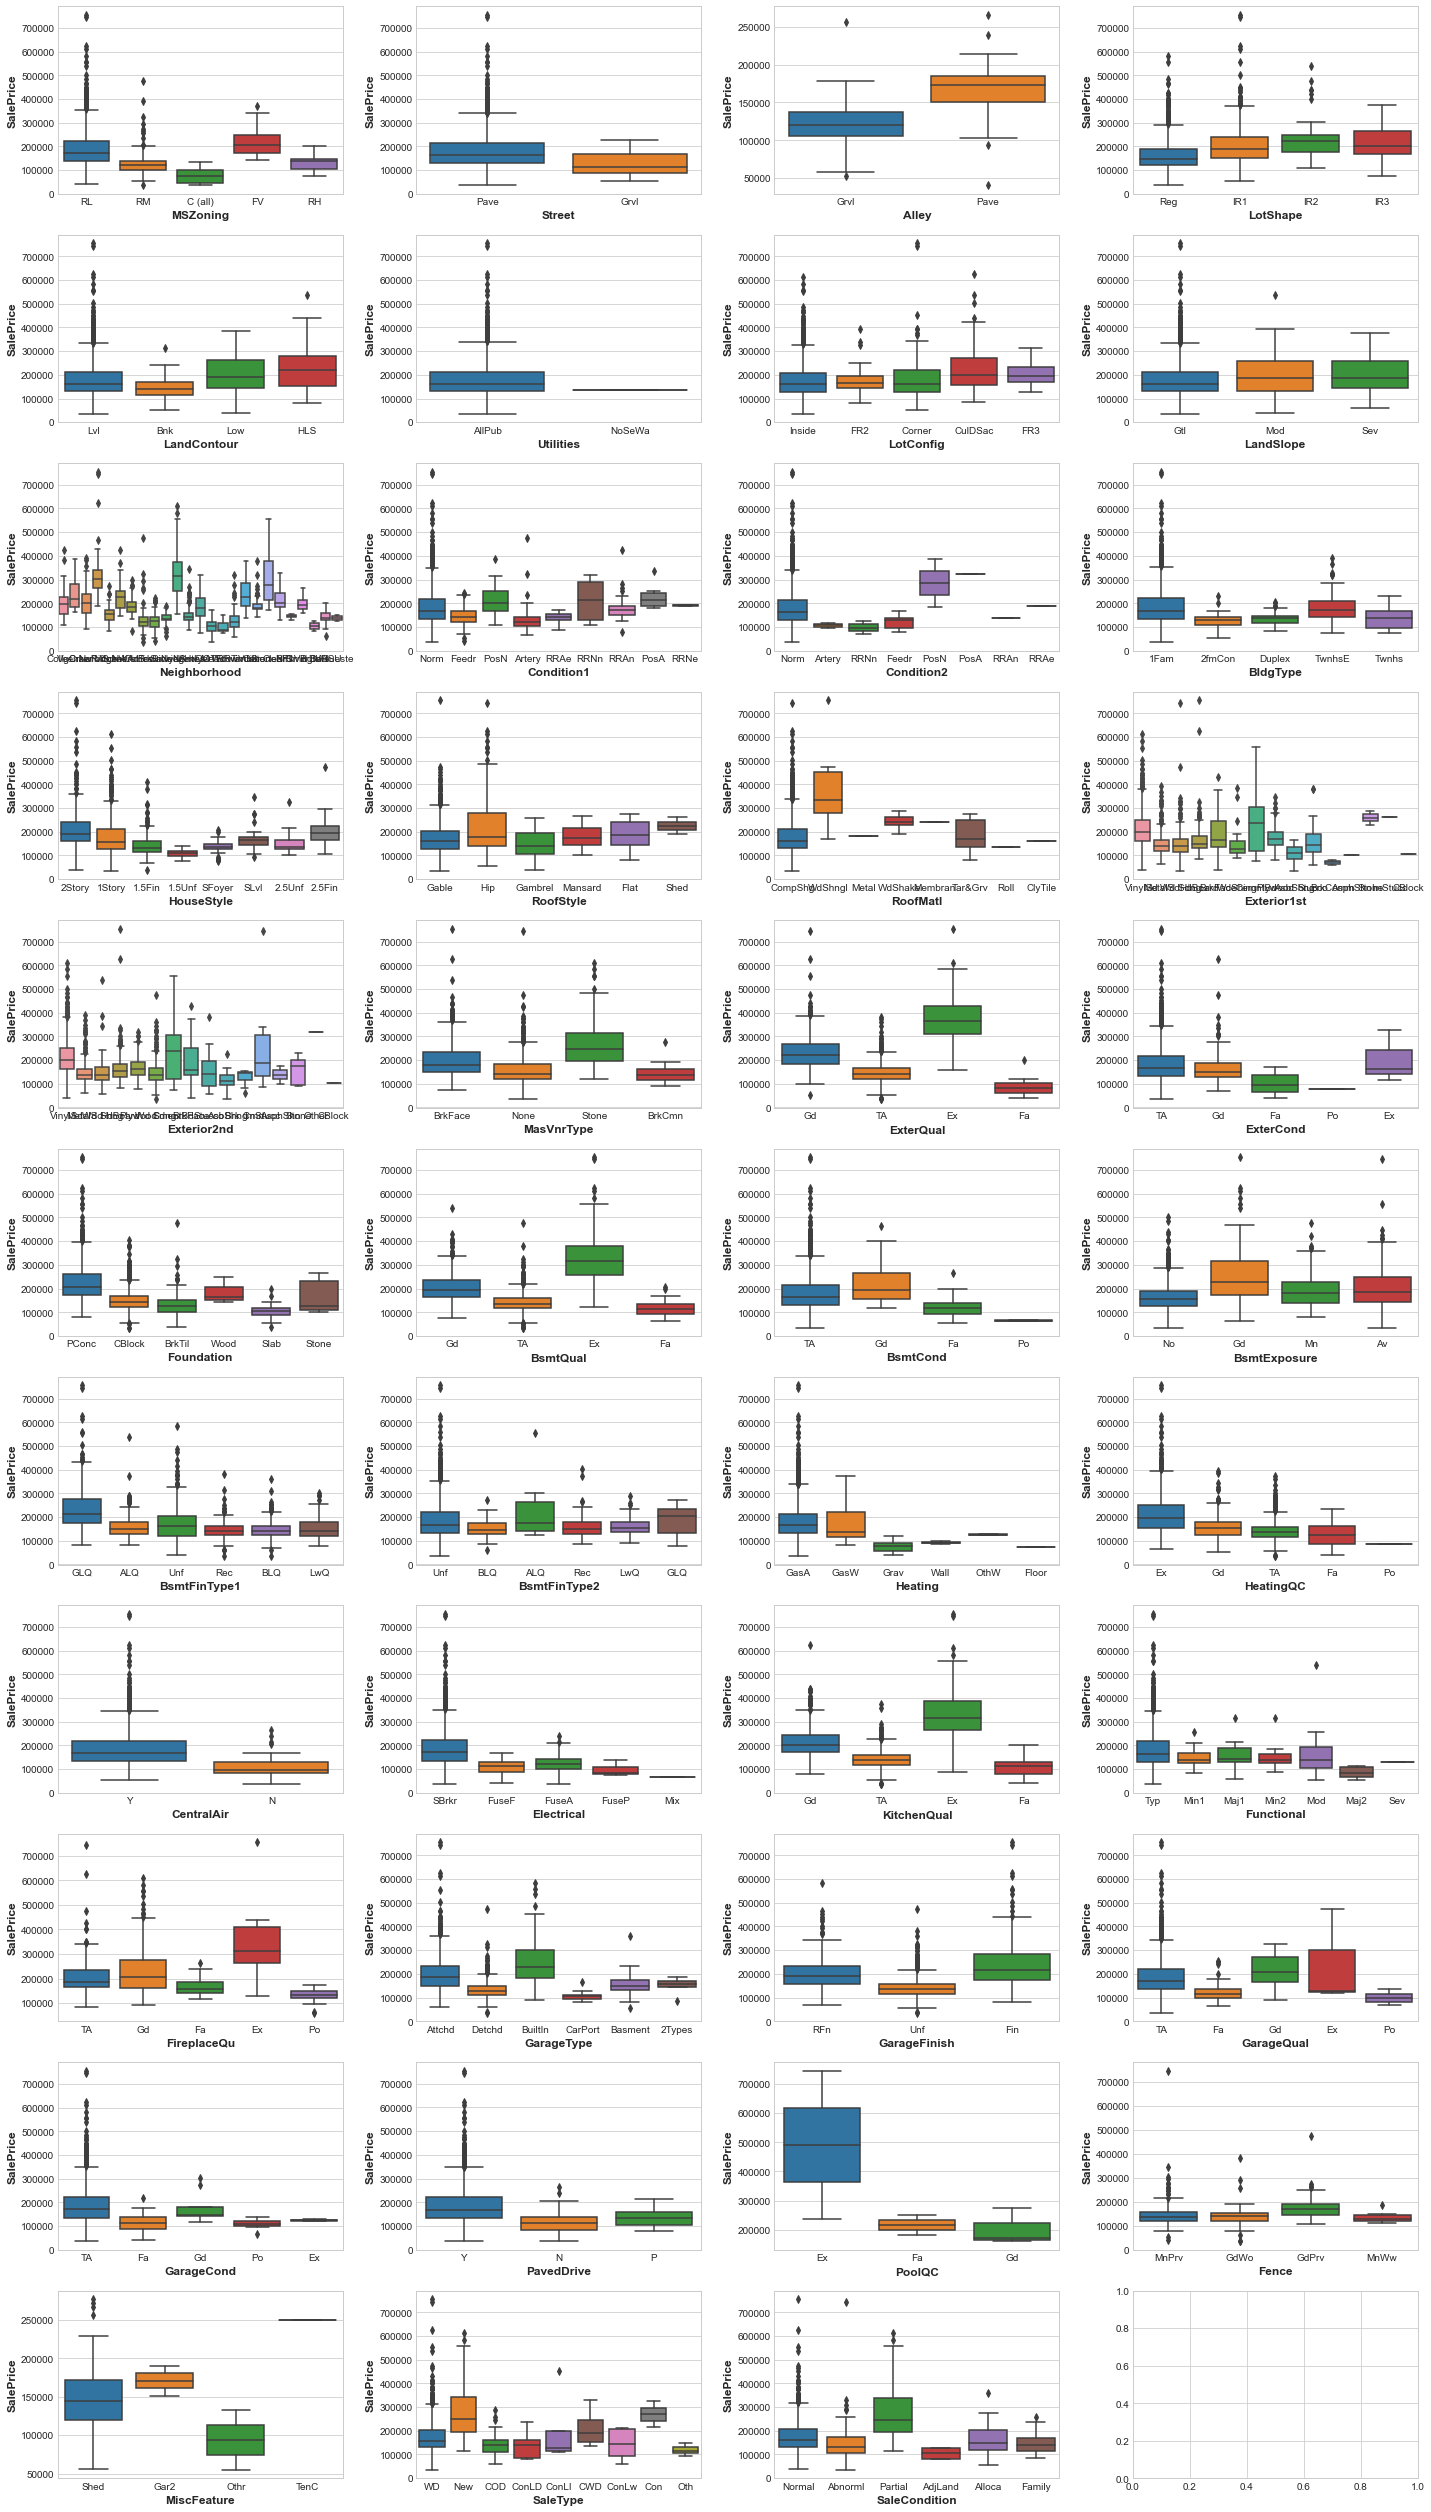

In [13]:
fig, axes = plt.subplots(11, 4, figsize=(20, 35))
fig.tight_layout(pad=8.0)

for i in range(len(categorical_cols)):
    sns.boxplot(x=df[categorical_cols[i]], y=df['SalePrice'], data=df, ax=axes[i//4, i%4])

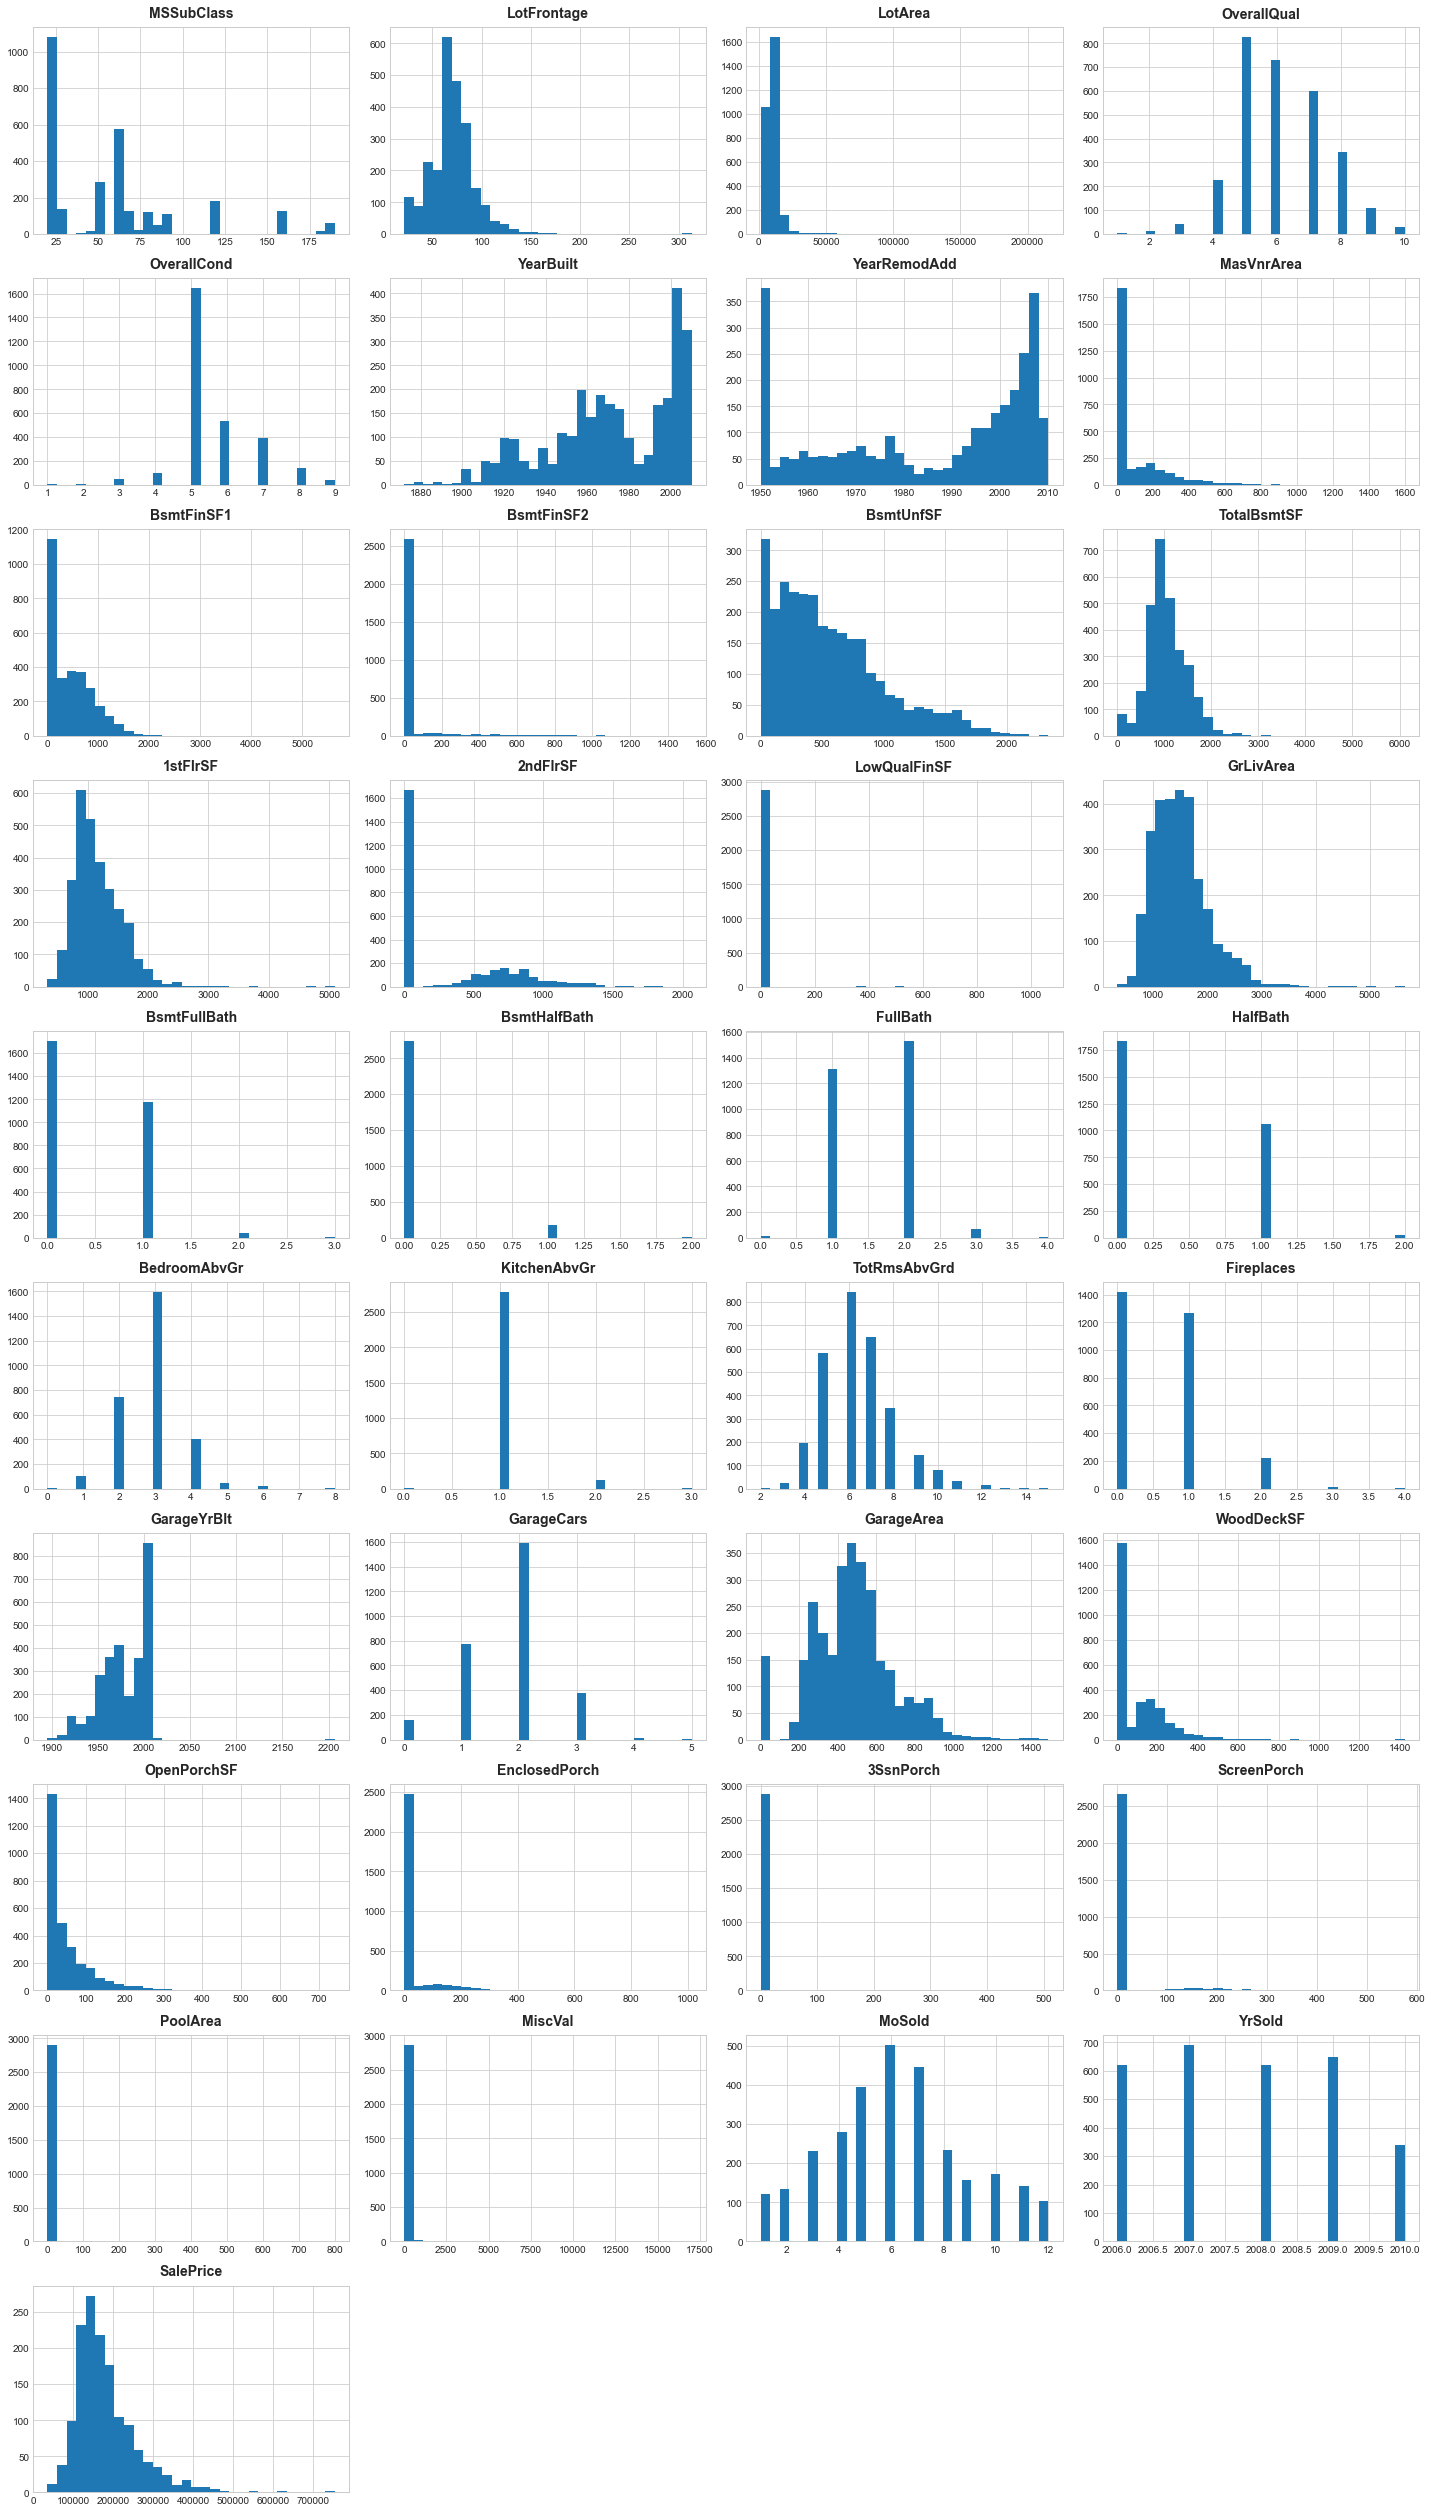

In [14]:
fig = plt.figure(figsize=(20, 35))
fig.tight_layout(pad=8.0)

for i in range(len(numerical_cols)):
    plt.subplot(10, 4, i+1)
    plt.hist(df[numerical_cols[i]], bins=30)
    plt.title(numerical_cols[i])

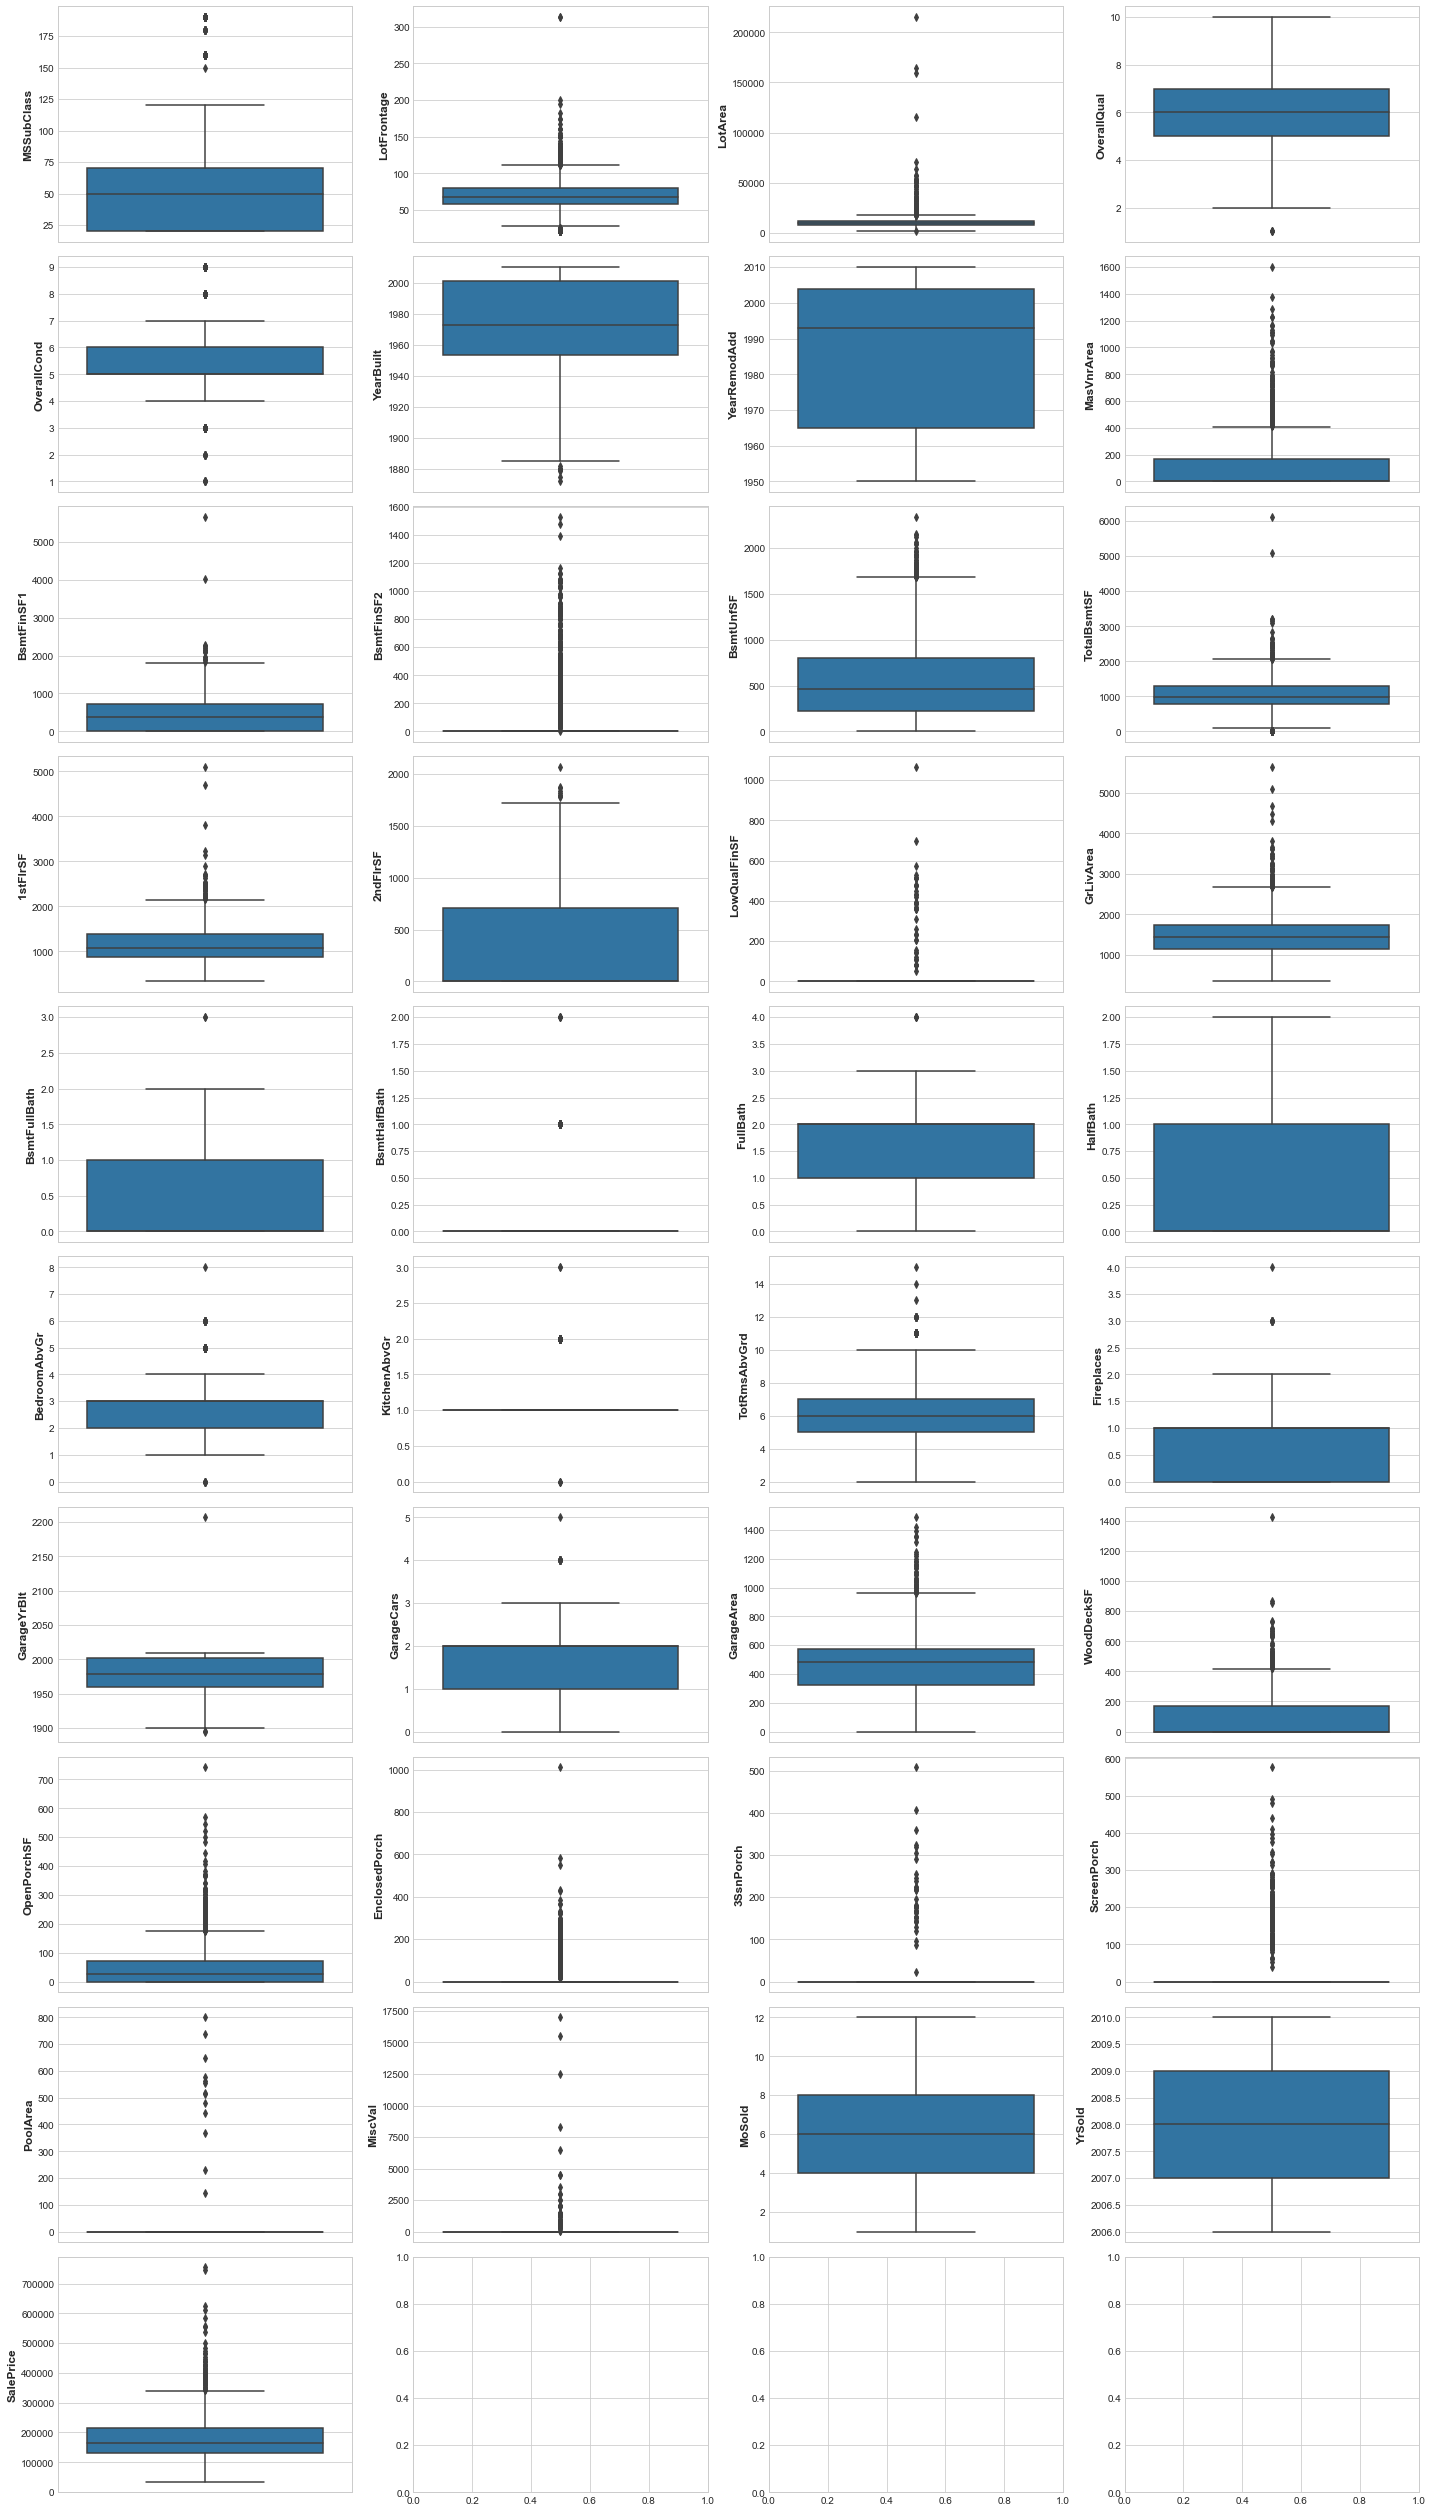

In [15]:
#sns.boxplot(y = 'LotFrontage', data=df)
#df[numerical_cols]
fig, axes = plt.subplots(10, 4, figsize=(20, 35))
fig.tight_layout(pad=8.0)
for i in range(len(numerical_cols)):
    sns.boxplot(ax=axes[i//4, i%4], y=df[numerical_cols[i]], data=df)

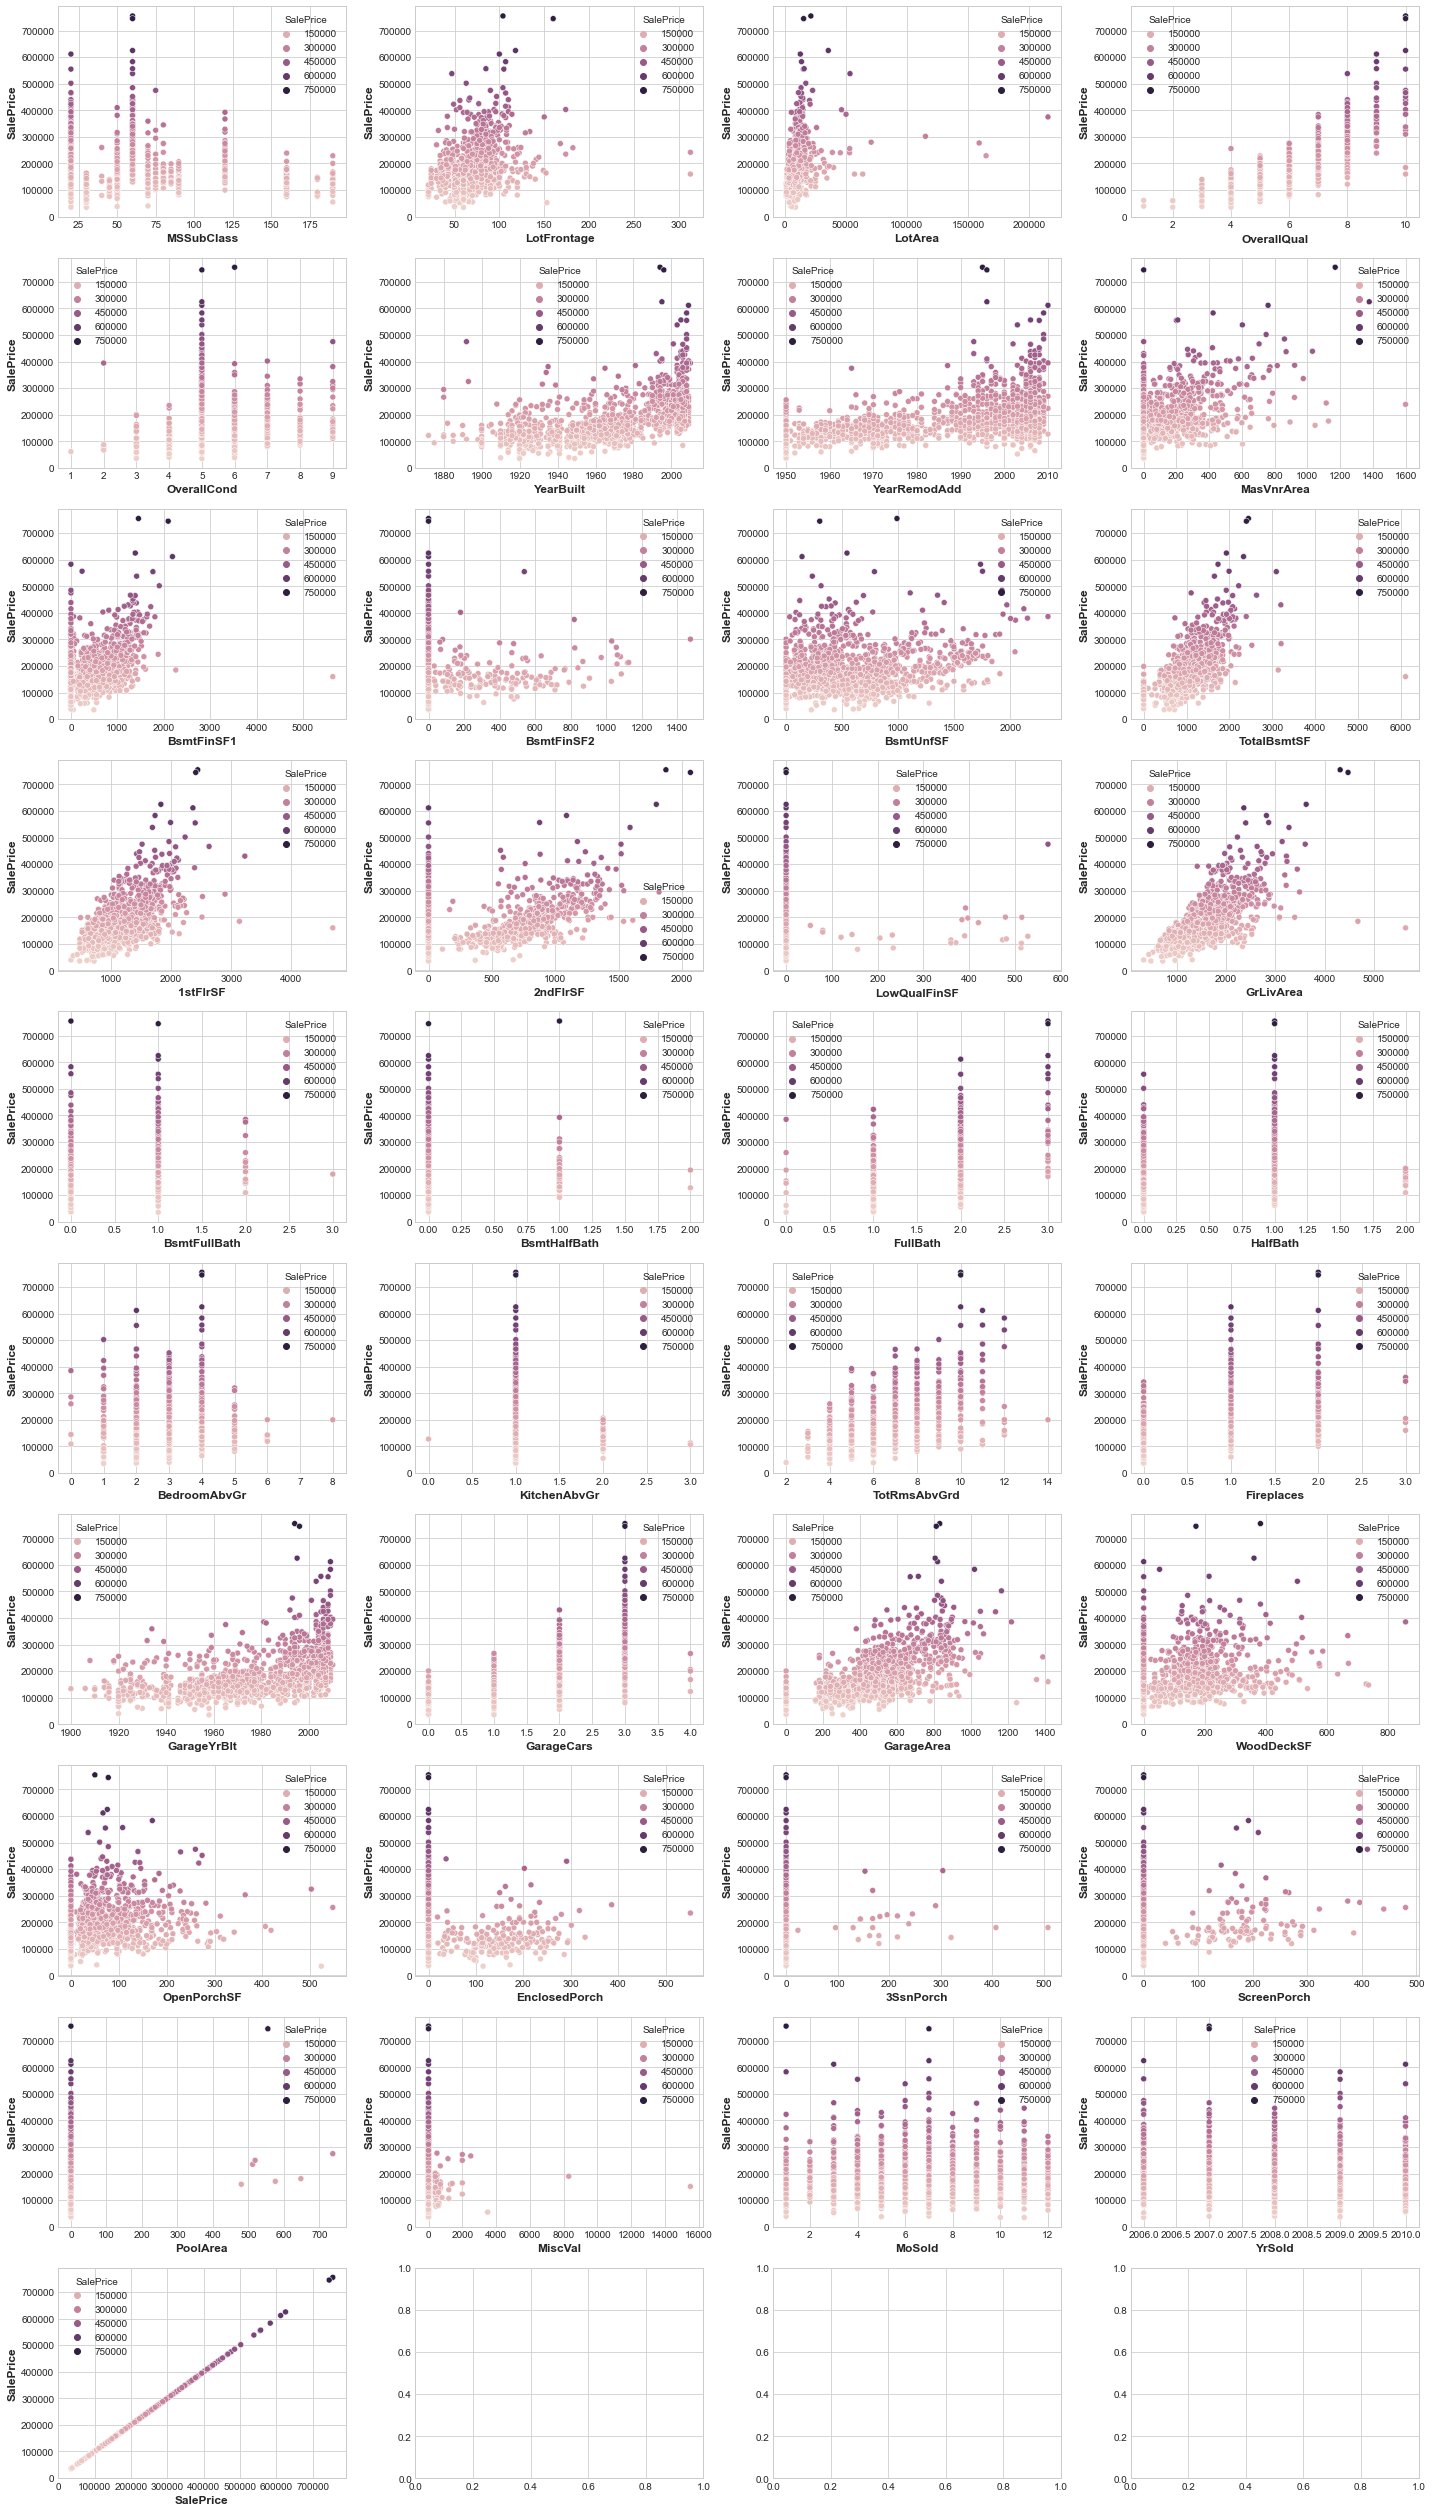

In [16]:
fig, axes = plt.subplots(10, 4, figsize=(20, 35))
fig.tight_layout(pad=8.0)

for i in range(len(numerical_cols)):
    sns.scatterplot(x=df[numerical_cols[i]], y=df['SalePrice'], data=df, ax=axes[i//4, i%4], hue=df['SalePrice'])

In [17]:
# takes numeric only?
#fig, axes = plt.subplots(figsize=(20, 35))
#fig.tight_layout(pad=8.0)
# Draw a multi-plot on every facet using `FacetGrid()`

#for i in range(len(numerical_cols)):
#g = sns.FacetGrid(df_train, col="SalePrice")
# Pass a function and the name of one or more columns in the dataframe
#g.map(plt.hist, "GarageCars", ax=axes);

In [18]:
#Learn Grouby 
#Learn outliers
#Split train data
#Learn Facetgrid
#Fill missing data
#Transform numerical values
#Handle categorical values
#	Must be numeric
#Outliers
#Split train data
#Early stopping and regularization


In [19]:
def load_data():
    # Read data
    #data_dir = Path("../input/house-prices-advanced-regression-techniques/")
    df_train = pd.read_csv("train.csv", index_col="Id")
    df_test = pd.read_csv("test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df) 
    df = impute(df) #impute non numeric columns
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

In [20]:
def clean(df):
    
    df["MSSubClass"] = df["MSSubClass"].astype("str") 
    df.loc[(df.MSZoning == "C (all)"), 'MSZoning'] = "C"
    df.loc[(df.MSZoning.isnull()) & (df.Neighborhood == "IDOTRR") & (df.MSSubClass == "20"), "MSZoning"] = "C"
    df.loc[(df.MSZoning.isnull()) & (df.Neighborhood == "Mitchel") & (df.MSSubClass == "20"), "MSZoning"] = "RL"
    
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Wd Shng": "WdShng"})
    df["Exterior2nd"] = df["Exterior2nd"].replace({"CmentBd": "CemntBd"})
    
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    df.loc[(df.GarageYrBlt == 2207), "GarageYrBlt"] = 2007
    df.loc[(df.GarageFinish.isnull()) & (df.GarageType.notnull()), "GarageFinish"] = "Fin"
    df.loc[(df.GarageCars.isnull()) & (df.GarageType.notnull()), "GarageCars"] = 1
    df.loc[(df.GarageQual.isnull()) & (df.GarageType.notnull()), "GarageQual"] = "TA"
    df.loc[(df.GarageCond.isnull()) & (df.GarageType.notnull()), "GarageCond"] = "TA"
    
    return df


In [21]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", 
                "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
                "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
                "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", 
                "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


In [22]:
def impute(df):
    #Assume Typical
    df['SaleType'].fillna(value="Oth", inplace=True)
    df['Functional'].fillna(value="Typ", inplace=True)
    
    #df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)
    #df['GarageArea'].fillna(df['GarageArea'].mean(), inplace=True)
    
   # for column in df[['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd']]:
   #     df[column].fillna(df[column].mode()[0], inplace=True)
    
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
        
    return df

In [23]:
df_train, df_test = load_data()

In [24]:
# Peek at the values
display(df_train)
display(df_test)

# Display information about dtypes and missing values
display(df_train.info())
display(df_test.info())

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                     
1            60       RL         65.0     8450   Pave  None      Reg   
2            20       RL         80.0     9600   Pave  None      Reg   
3            60       RL         68.0    11250   Pave  None      IR1   
4            70       RL         60.0     9550   Pave  None      IR1   
5            60       RL         84.0    14260   Pave  None      IR1   
...         ...      ...          ...      ...    ...   ...      ...   
1456         60       RL         62.0     7917   Pave  None      Reg   
1457         20       RL         85.0    13175   Pave  None      Reg   
1458         70       RL         66.0     9042   Pave  None      Reg   
1459         20       RL         68.0     9717   Pave  None      Reg   
1460         20       RL         75.0     9937   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                       
1            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
1456         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1457         Lvl    AllPub    Inside       Gtl       NWAmes       Norm   
1458         Lvl    AllPub    Inside       Gtl      Crawfor       Norm   
1459         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1460         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle OverallQual OverallCond  YearBuilt  \
Id                                                                       
1          Norm     1Fam     2Story           7           5       2003   
2          Norm     1Fam     1Story           6           8       1976   
3          Norm     1Fam     2Story           7           5       2001   
4          Norm     1Fam     2Story           7           5       1915   
5          Norm     1Fam     2Story           8           5       2000   
...         ...      ...        ...         ...         ...        ...   
1456       Norm     1Fam     2Story           6           5       1999   
1457       Norm     1Fam     1Story           6           6       1978   
1458       Norm     1Fam     2Story           7           9       1941   
1459       Norm     1Fam     1Story           5           6       1950   
1460       Norm     1Fam     1Story           5           6       1965   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                         
1             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2             1976     Gable  CompShg     MetalSd     MetalSd       None   
3             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4             1970     Gable  CompShg     Wd Sdng      WdShng       None   
5             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
1456          2000     Gable  CompShg     VinylSd     VinylSd       None   
1457          1988     Gable  CompShg     Plywood     Plywood      Stone   
1458          2006     Gable  CompShg     CemntBd     CemntBd       None   
1459          1996       Hip  CompShg     MetalSd     MetalSd       None   
1460          1965     Gable  CompShg     HdBoard     HdBoard       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                  
1          196.

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                     
1461         20       RH         80.0    11622   Pave  None      Reg   
1462         20       RL         81.0    14267   Pave  None      IR1   
1463         60       RL         74.0    13830   Pave  None      IR1   
1464         60       RL         78.0     9978   Pave  None      IR1   
1465        120       RL         43.0     5005   Pave  None      IR1   
...         ...      ...          ...      ...    ...   ...      ...   
2915        160       RM         21.0     1936   Pave  None      Reg   
2916        160       RM         21.0     1894   Pave  None      Reg   
2917         20       RL        160.0    20000   Pave  None      Reg   
2918         85       RL         62.0    10441   Pave  None      Reg   
2919         60       RL         74.0     9627   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                       
1461         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1462         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
1463         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1464         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1465         HLS    AllPub    Inside       Gtl      StoneBr       Norm   
...          ...       ...       ...       ...          ...        ...   
2915         Lvl    AllPub    Inside       Gtl      MeadowV       Norm   
2916         Lvl    AllPub    Inside       Gtl      MeadowV       Norm   
2917         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
2918         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
2919         Lvl    AllPub    Inside       Mod      Mitchel       Norm   

     Condition2 BldgType HouseStyle OverallQual OverallCond  YearBuilt  \
Id                                                                       
1461       Norm     1Fam     1Story           5           6       1961   
1462       Norm     1Fam     1Story           6           6       1958   
1463       Norm     1Fam     2Story           5           5       1997   
1464       Norm     1Fam     2Story           6           6       1998   
1465       Norm   TwnhsE     1Story           8           5       1992   
...         ...      ...        ...         ...         ...        ...   
2915       Norm    Twnhs     2Story           4           7       1970   
2916       Norm   TwnhsE     2Story           4           5       1970   
2917       Norm     1Fam     1Story           5           7       1960   
2918       Norm     1Fam     SFoyer           5           5       1992   
2919       Norm     1Fam     2Story           7           5       1993   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                         
1461          1961     Gable  CompShg     VinylSd     VinylSd       None   
1462          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
1463          1998     Gable  CompShg     VinylSd     VinylSd       None   
1464          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1465          1992     Gable  CompShg     HdBoard     HdBoard       None   
...            ...       ...      ...         ...         ...        ...   
2915          1970     Gable  CompShg     CemntBd     CemntBd       None   
2916          1970     Gable  CompShg     CemntBd     CemntBd       None   
2917          1996     Gable  CompShg     VinylSd     VinylSd       None   
2918          1992     Gable  CompShg     HdBoard      WdShng       None   
2919          1994     Gable  CompShg     HdBoard     HdBoard    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                  
1461         0.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 n

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1459 non-null   category
 1   MSZoning          1459 non-null   category
 2   LotFrontage       1459 non-null   float64 
 3   LotArea           1459 non-null   int64   
 4   Street            1459 non-null   category
 5   Alley             1459 non-null   category
 6   LotShape          1459 non-null   category
 7   LandContour       1459 non-null   category
 8   Utilities         1459 non-null   category
 9   LotConfig         1459 non-null   category
 10  LandSlope         1459 non-null   category
 11  Neighborhood      1459 non-null   category
 12  Condition1        1459 non-null   category
 13  Condition2        1459 non-null   category
 14  BldgType          1459 non-null   category
 15  HouseStyle        1459 non-null   category
 16  OverallQual       145

None

In [25]:
#Categorical columns
categorical_cols = [cname for cname in df_train.columns if  
                   df_train[cname].dtype not in ['int64', 'float64']]

#Select numerical columns
numerical_cols = [cname for cname in df_train.columns if 
                df_train[cname].dtype in ['int64', 'float64']]

In [26]:
print(categorical_cols)
print(len(categorical_cols))
print("-------")
print(numerical_cols)
print(len(numerical_cols))

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
46
-------
['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenP

In [27]:
missing(df_train)

Empty DataFrame
Columns: [no_missing_values, missing_value_ratio, missing_in_train, missing_in_test]
Index: []

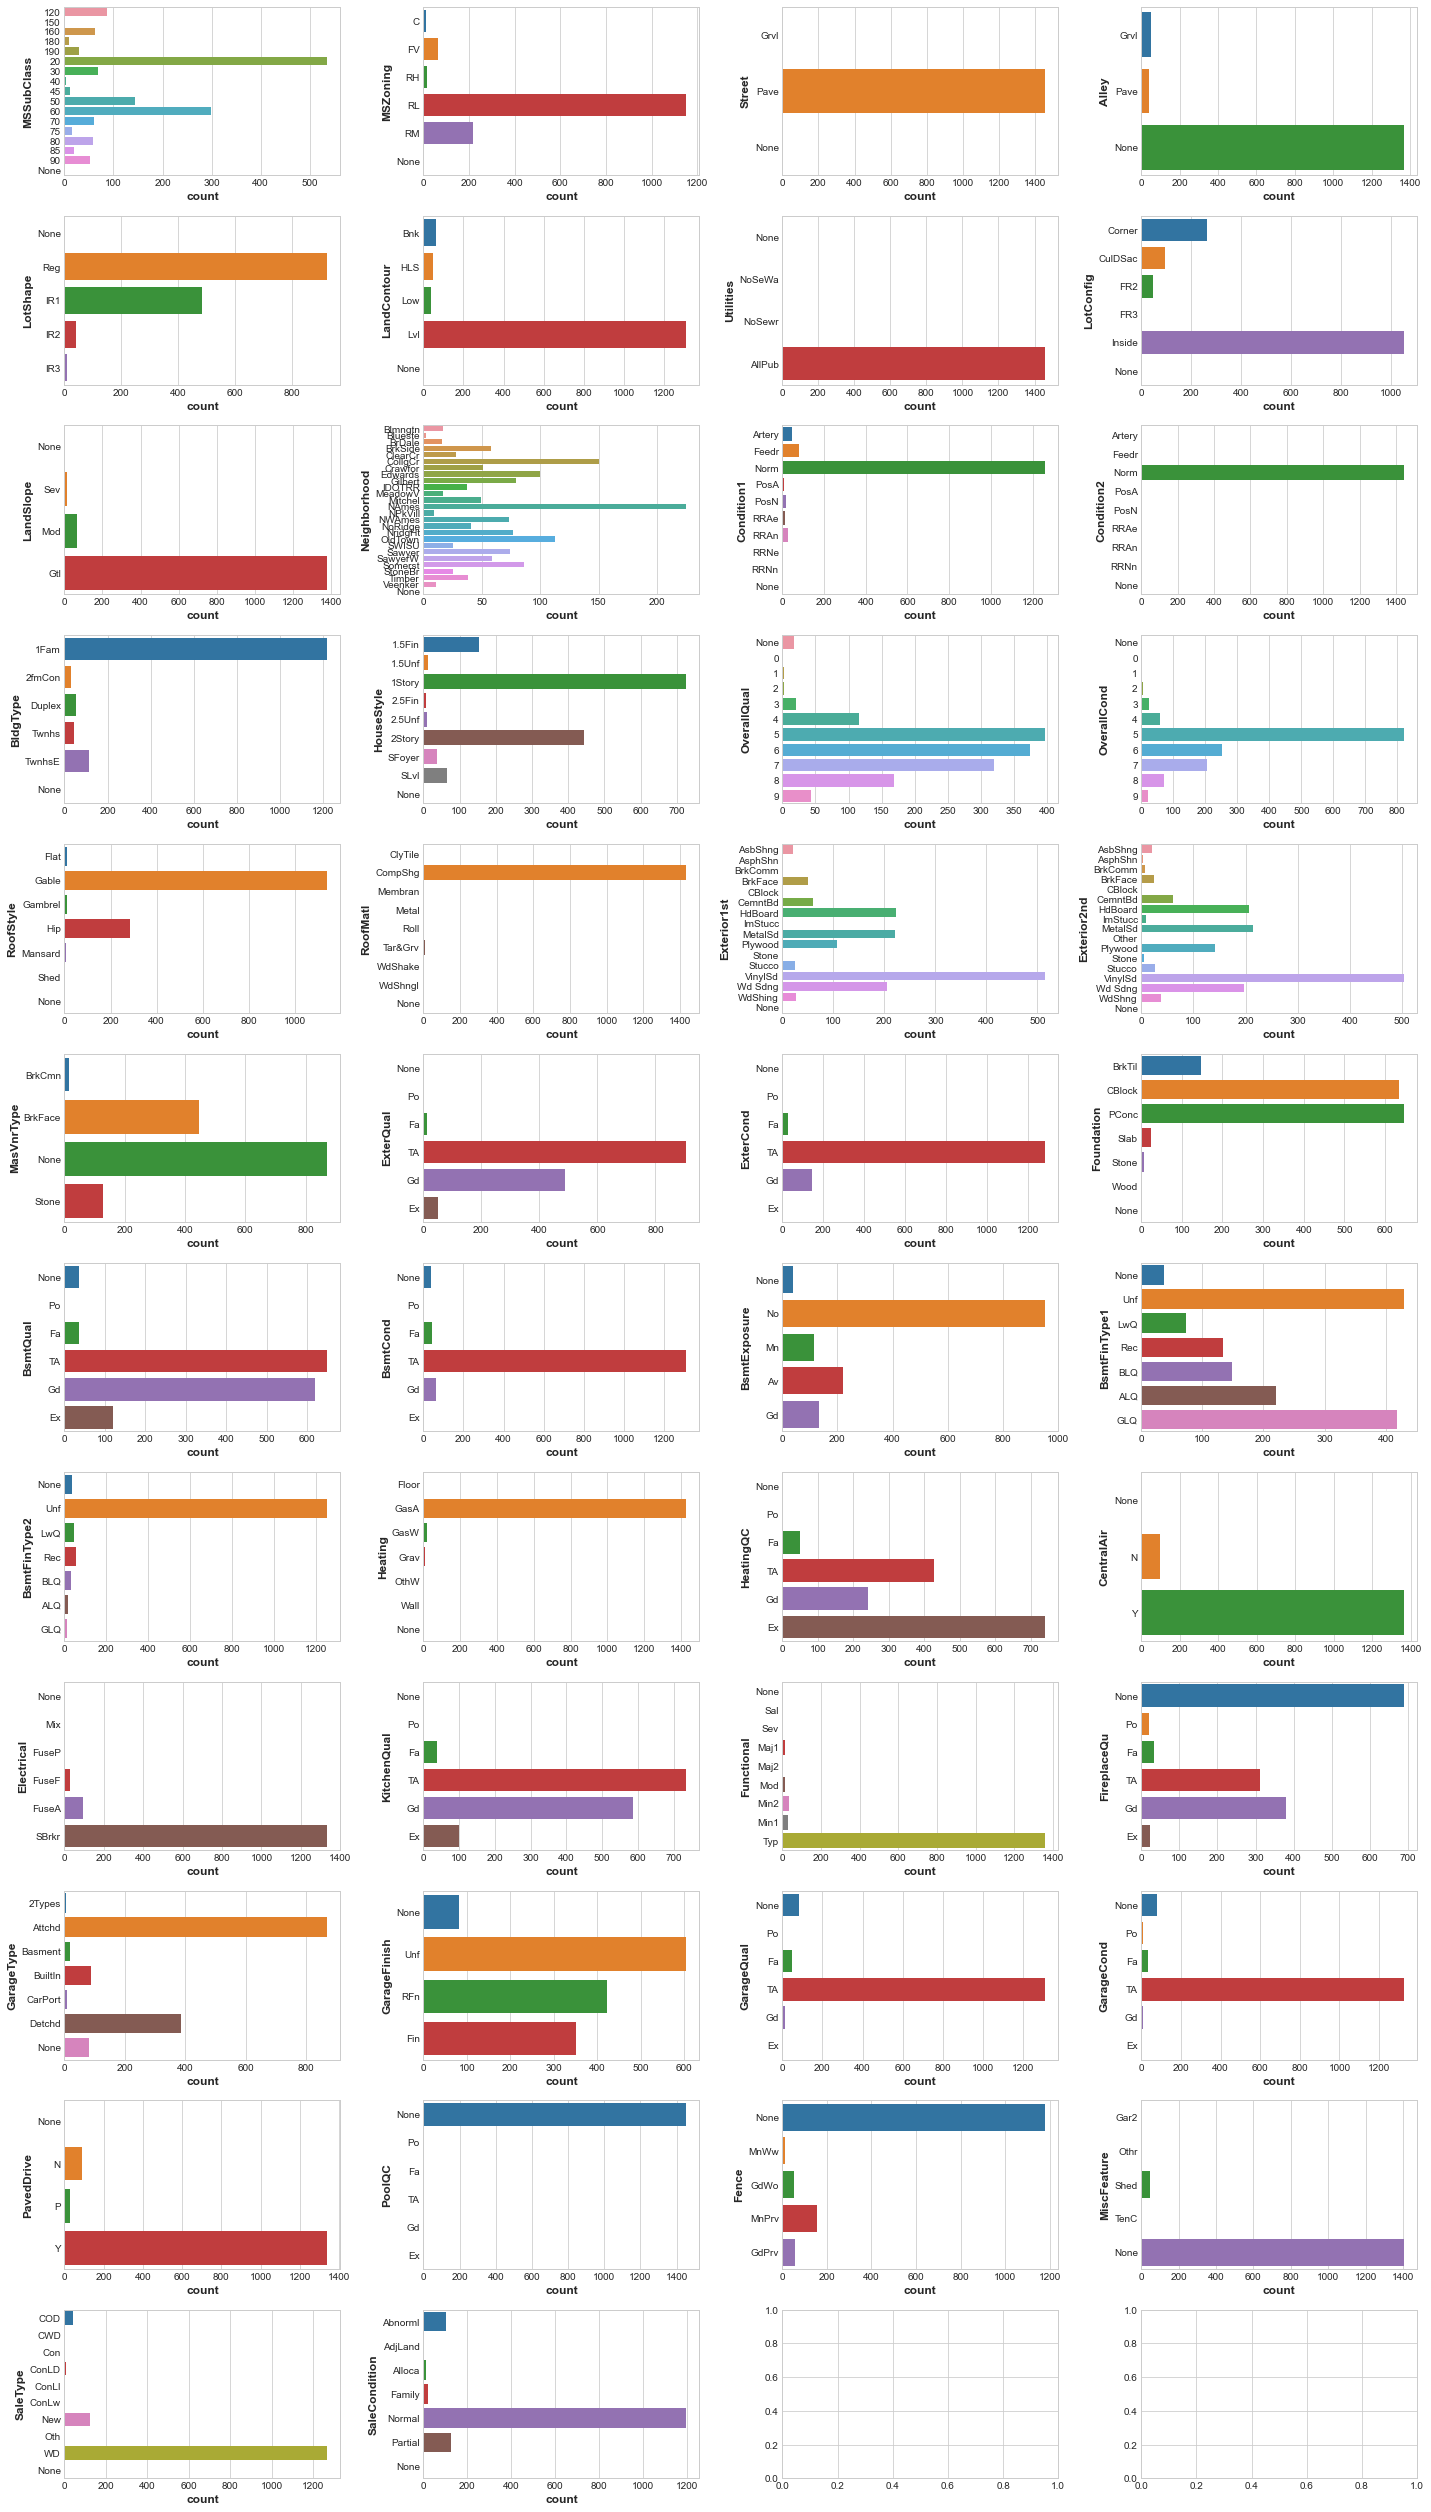

In [28]:
fig, axes = plt.subplots(12, 4, figsize=(20, 35))
fig.tight_layout(pad=8.0)
for i in range(len(categorical_cols)):
    sns.countplot(ax=axes[i//4, i%4], y=df_train[categorical_cols[i]], data=df)

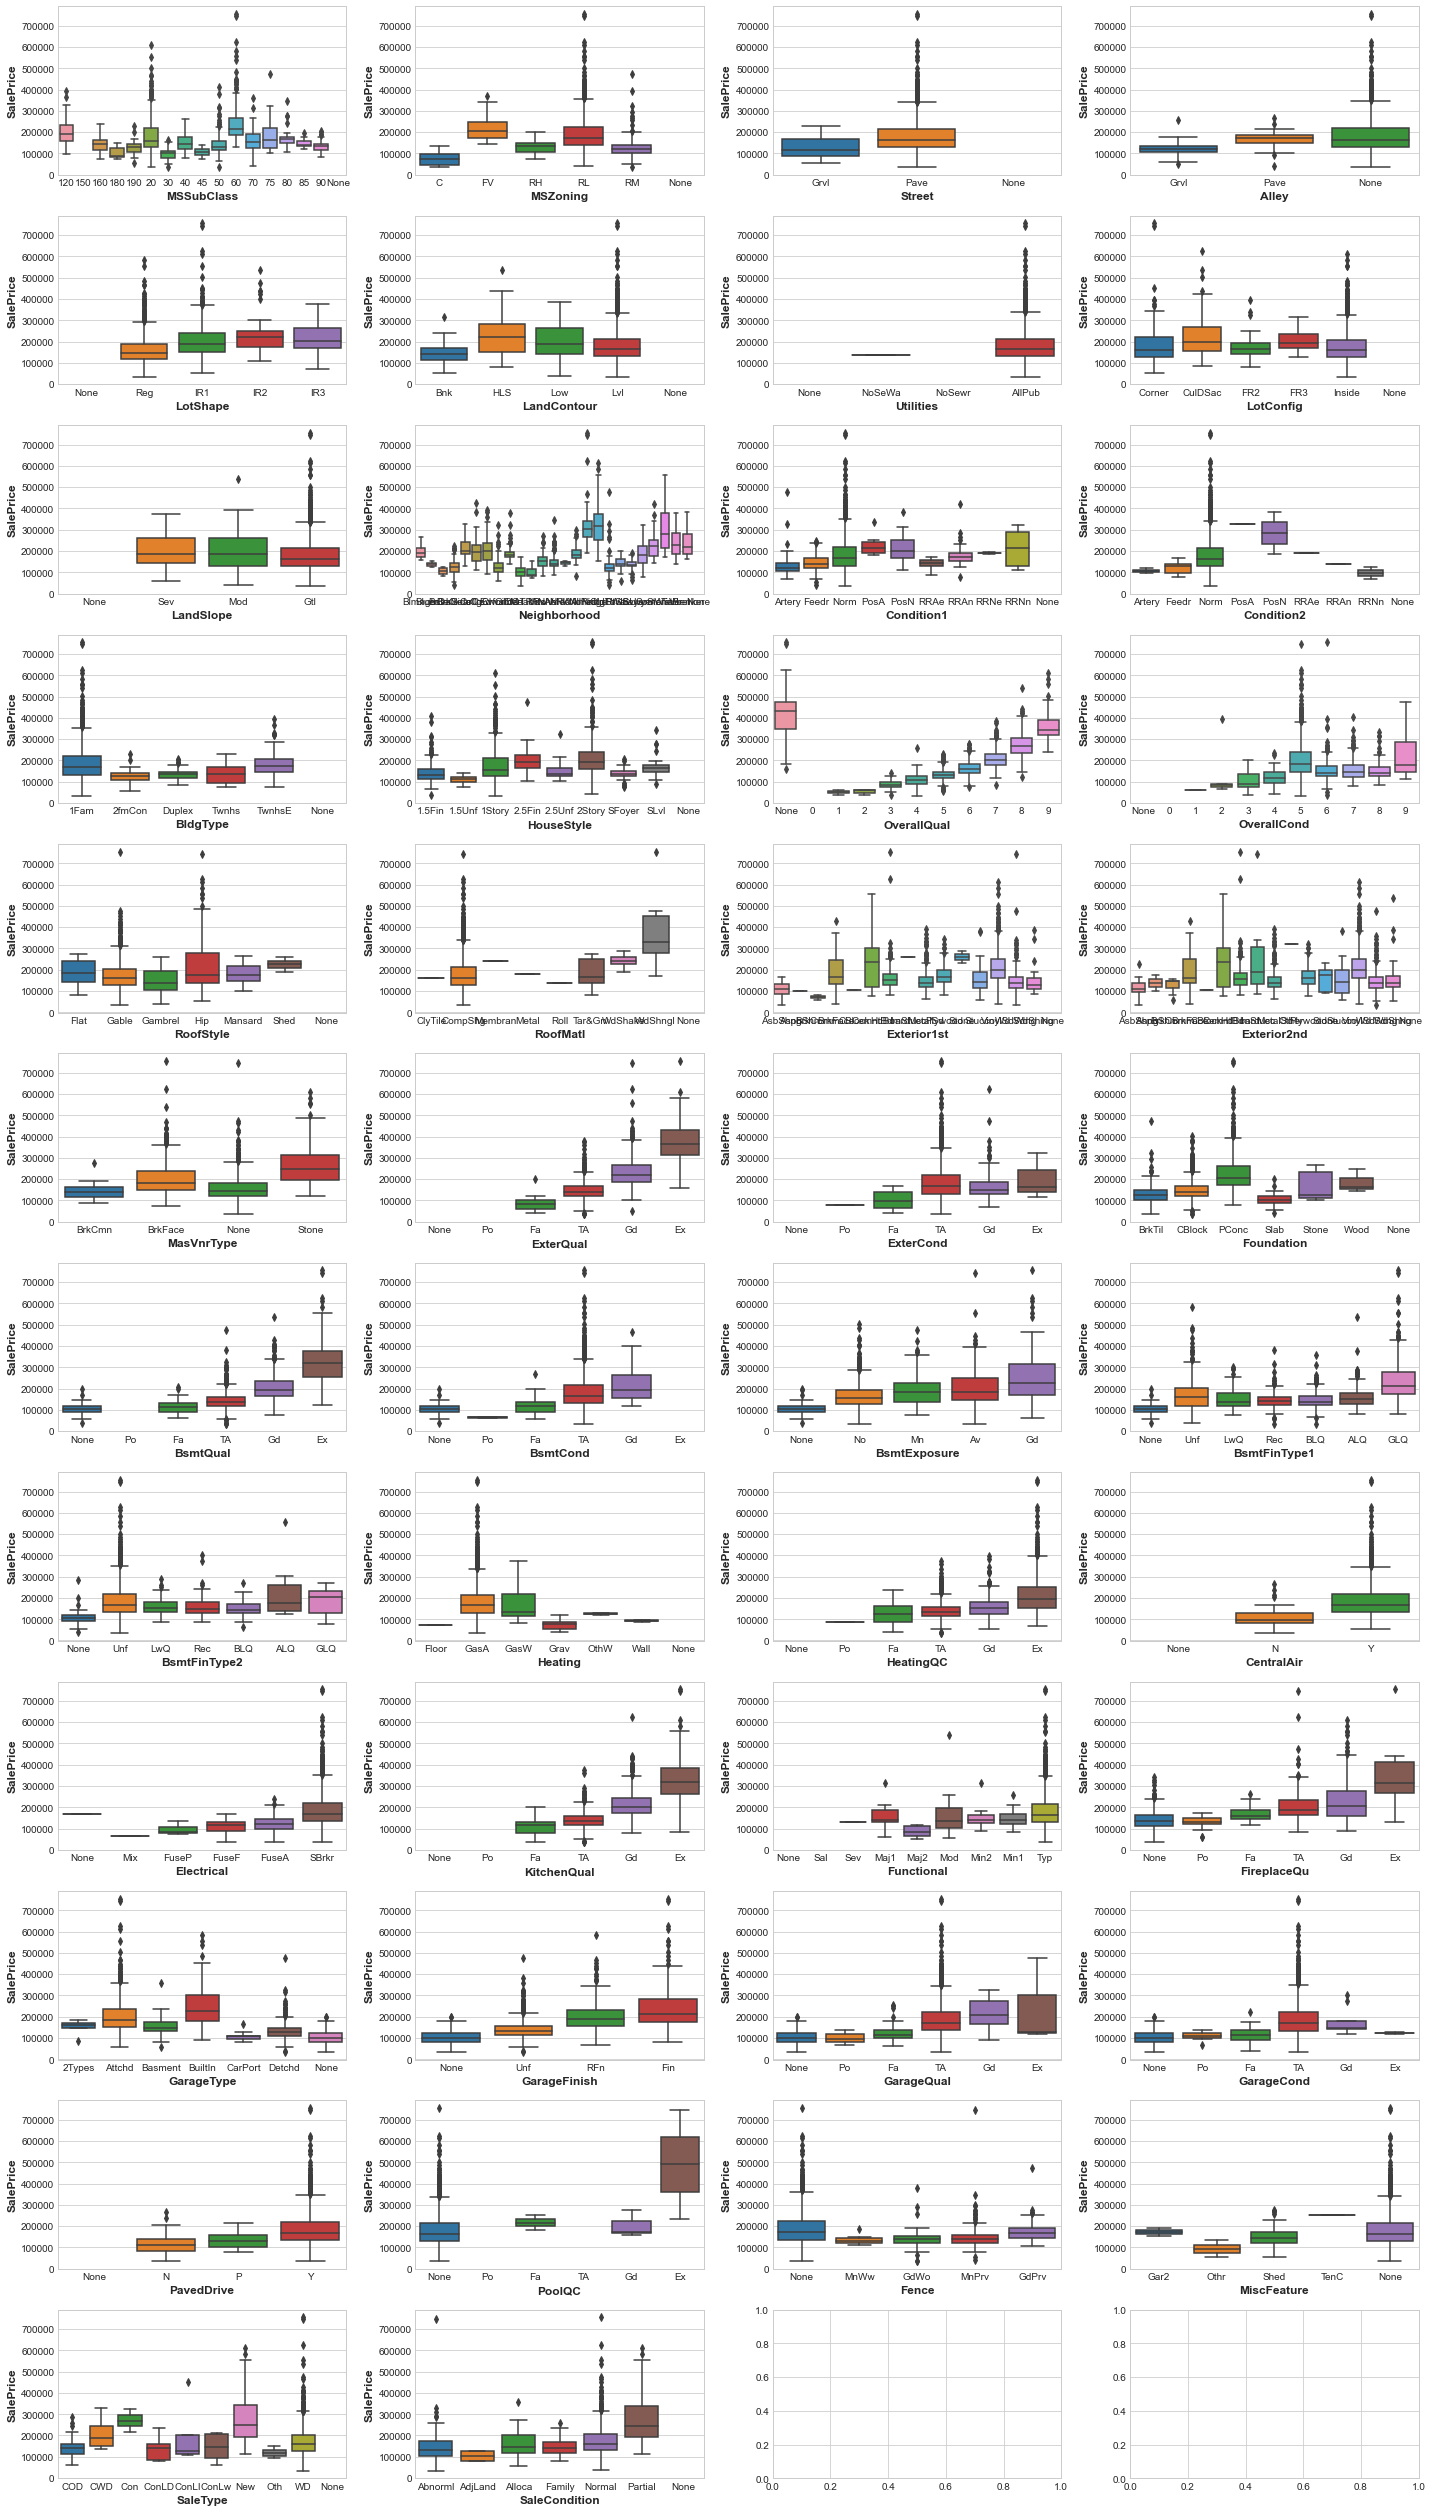

In [29]:
fig, axes = plt.subplots(12, 4, figsize=(20, 35))
fig.tight_layout(pad=8.0)

for i in range(len(categorical_cols)):
    sns.boxplot(x=df_train[categorical_cols[i]], y=df_train['SalePrice'], data=df_train, ax=axes[i//4, i%4])

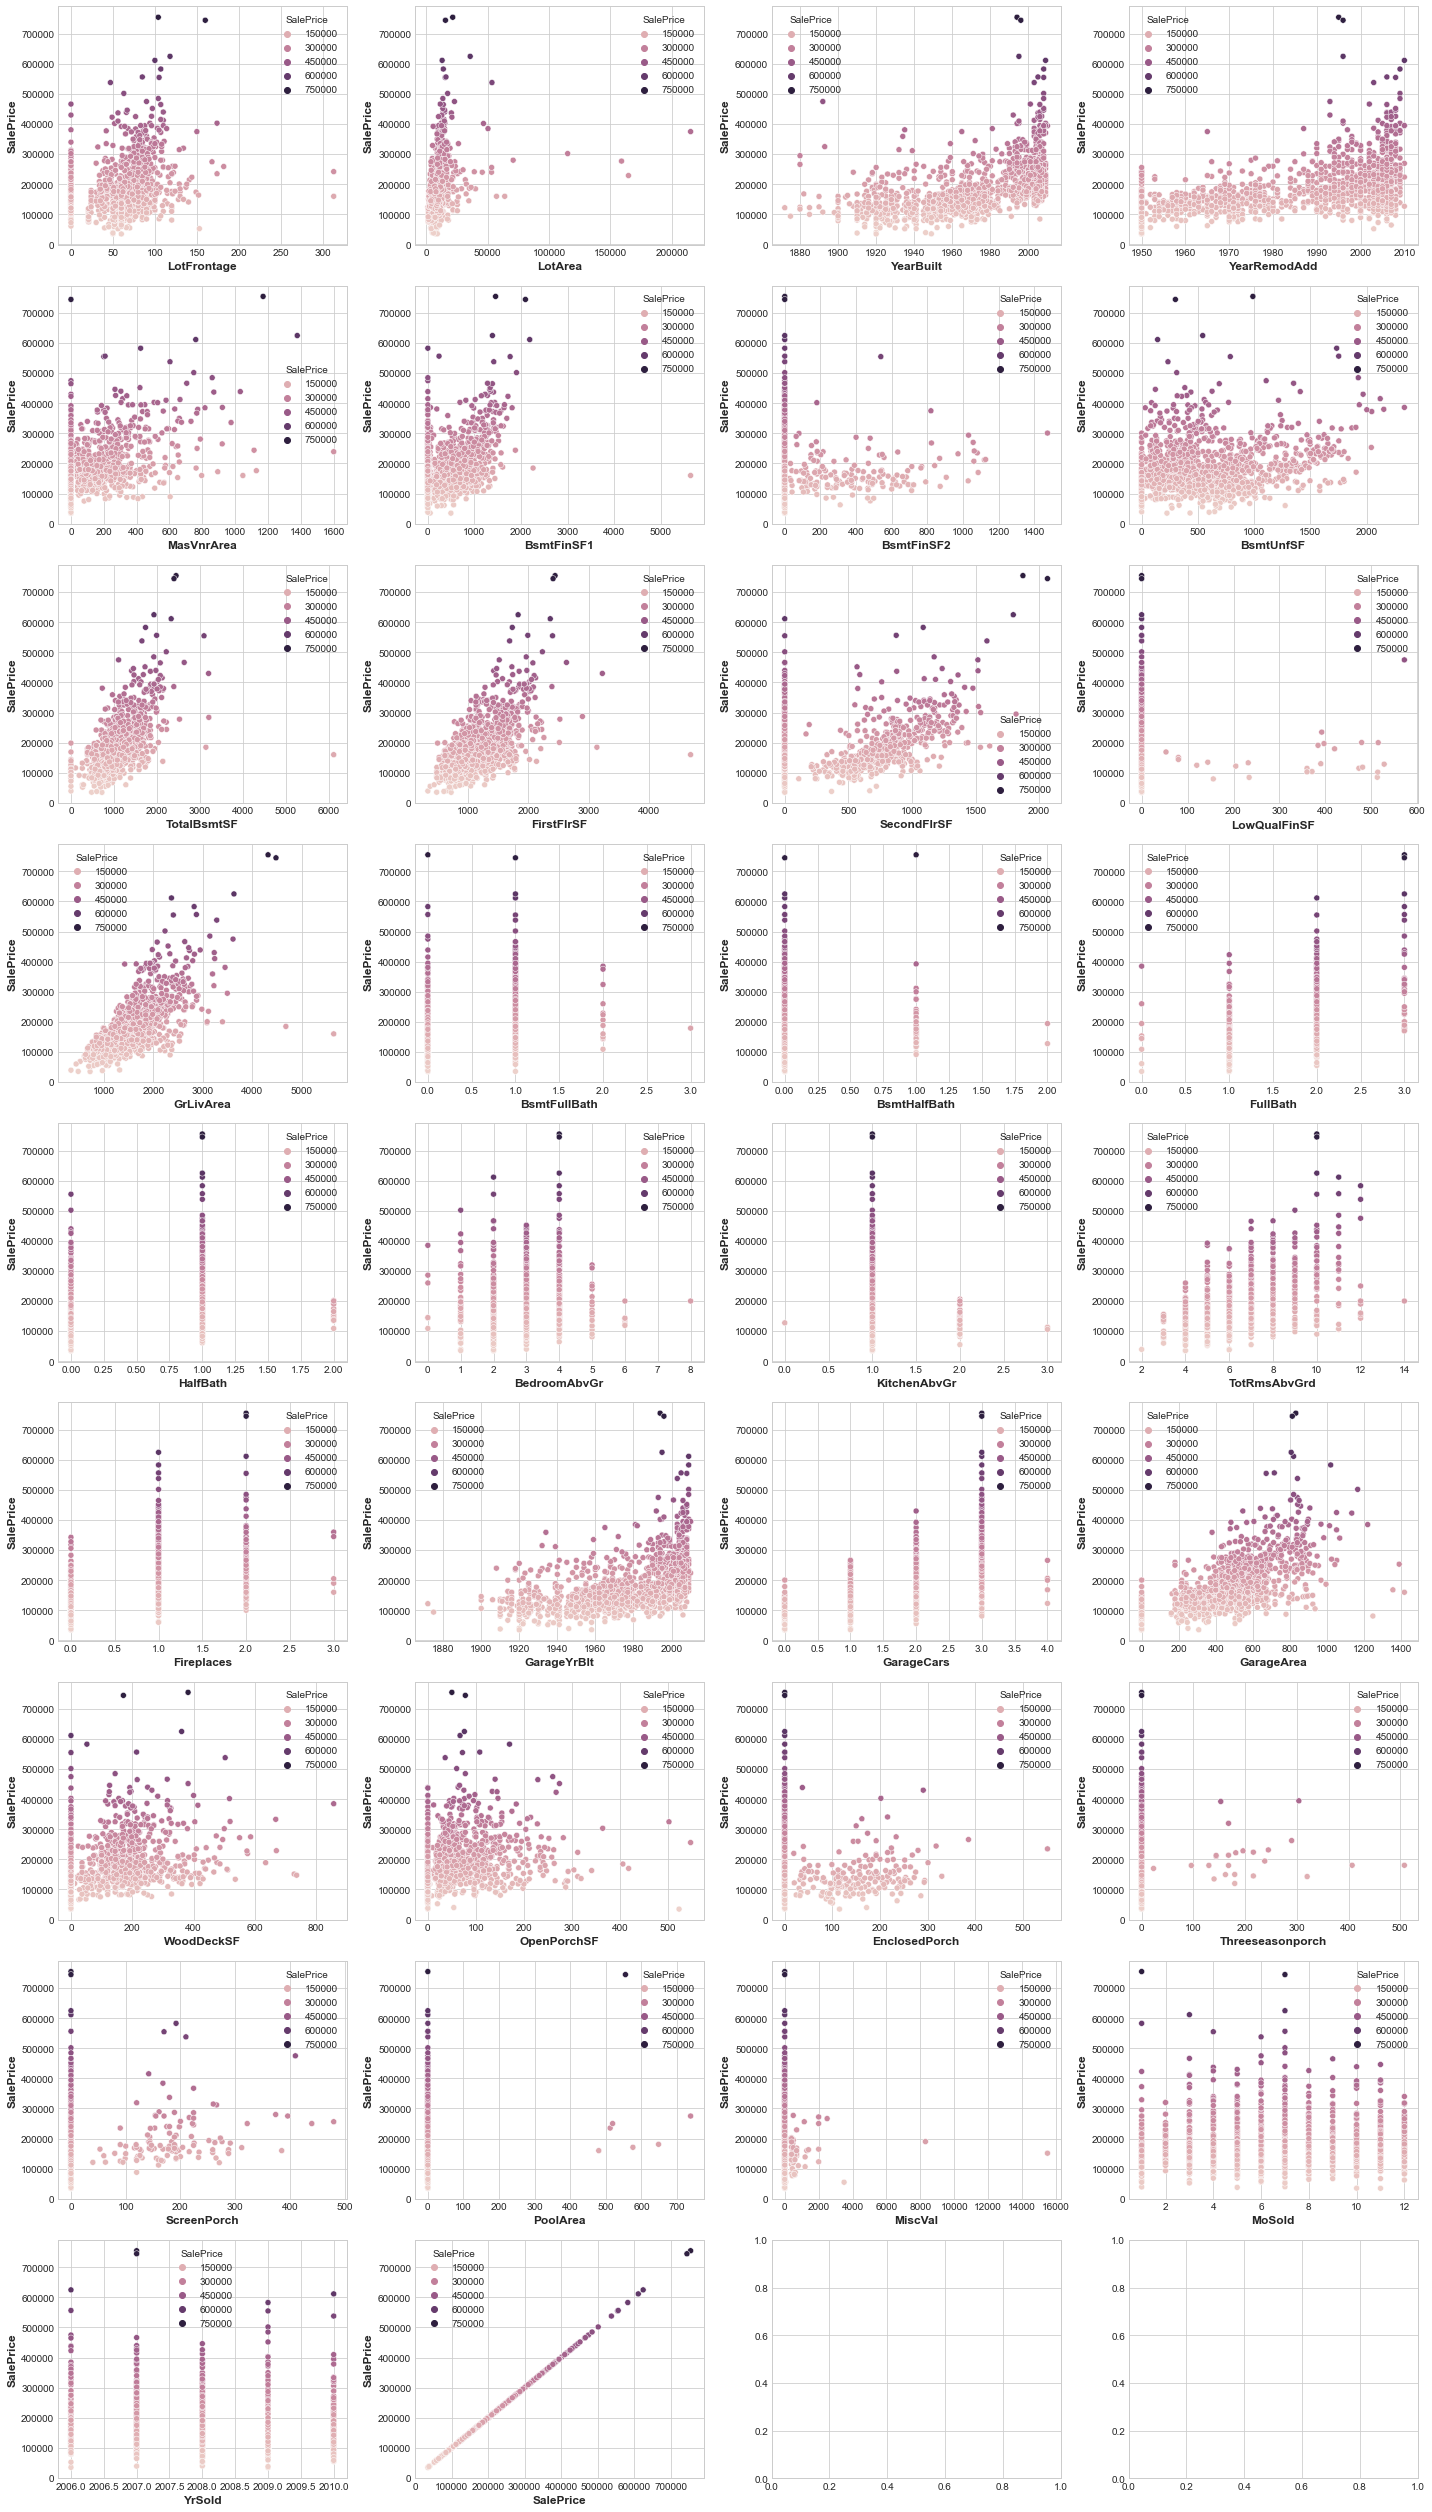

In [30]:
fig, axes = plt.subplots(9, 4, figsize=(20, 35))
fig.tight_layout(pad=8.0)

for i in range(len(numerical_cols)):
    sns.scatterplot(x=df_train[numerical_cols[i]], y=df_train['SalePrice'], data=df_train, ax=axes[i//4, i%4], hue=df_train['SalePrice'])

In [31]:
missing(df_test)

Empty DataFrame
Columns: [no_missing_values, missing_value_ratio, missing_in_train, missing_in_test]
Index: []

In [32]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    #plt.title("Mutual Information Scores")

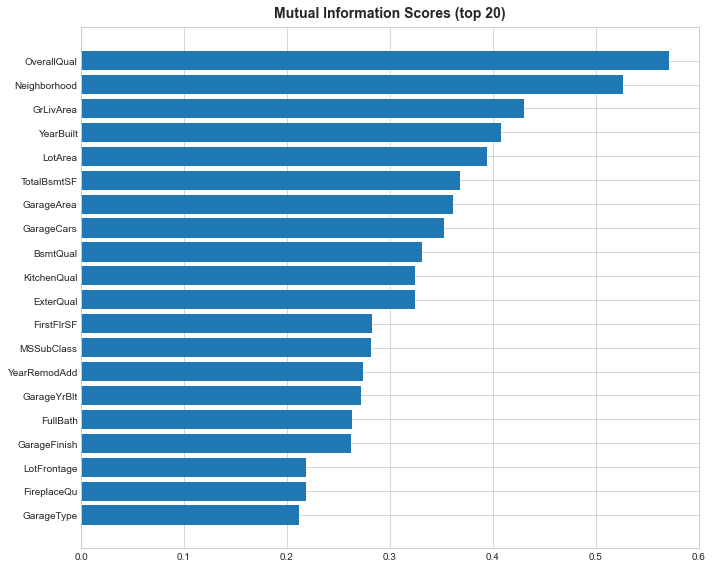

In [33]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
plt.figure(figsize=(10, 8))
plt.title("Mutual Information Scores (top 20)")
plot_mi_scores(mi_scores.head(20))


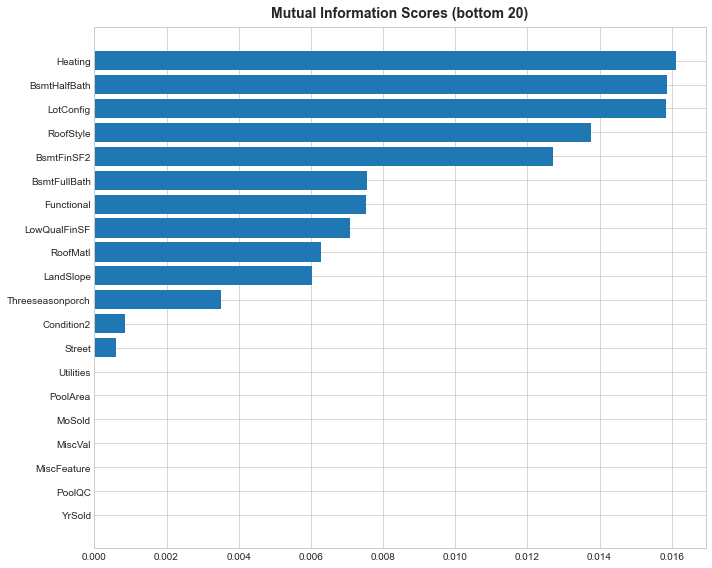

In [34]:
plt.figure(figsize=(10, 8))
plt.title("Mutual Information Scores (bottom 20)")
plot_mi_scores(mi_scores.tail(20))

<AxesSubplot:>

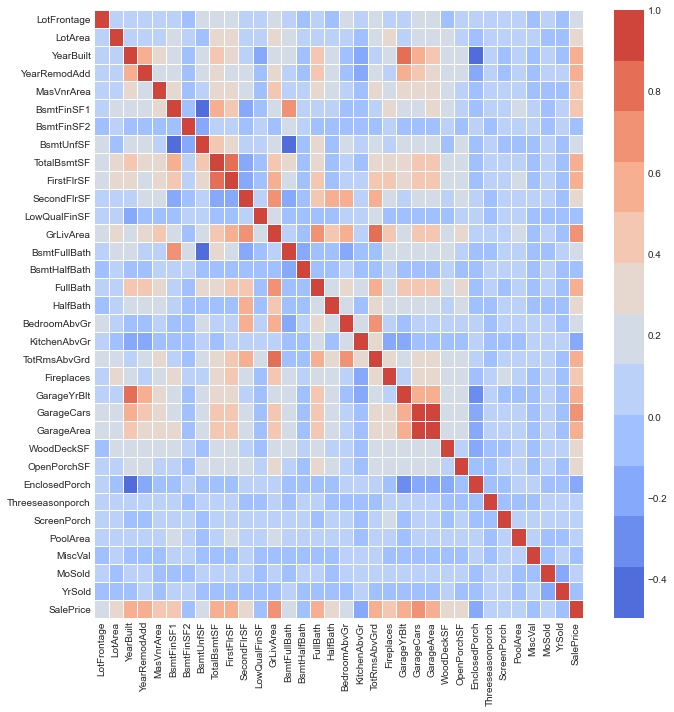

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
colormap = sns.color_palette("coolwarm", 12)#("viridis", as_cmap=True)
sns.heatmap(df_train.corr(), linewidths=.5, ax=ax, cmap=colormap)

In [36]:
df_train

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                     
1            60       RL         65.0     8450   Pave  None      Reg   
2            20       RL         80.0     9600   Pave  None      Reg   
3            60       RL         68.0    11250   Pave  None      IR1   
4            70       RL         60.0     9550   Pave  None      IR1   
5            60       RL         84.0    14260   Pave  None      IR1   
...         ...      ...          ...      ...    ...   ...      ...   
1456         60       RL         62.0     7917   Pave  None      Reg   
1457         20       RL         85.0    13175   Pave  None      Reg   
1458         70       RL         66.0     9042   Pave  None      Reg   
1459         20       RL         68.0     9717   Pave  None      Reg   
1460         20       RL         75.0     9937   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                       
1            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
1456         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1457         Lvl    AllPub    Inside       Gtl       NWAmes       Norm   
1458         Lvl    AllPub    Inside       Gtl      Crawfor       Norm   
1459         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1460         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle OverallQual OverallCond  YearBuilt  \
Id                                                                       
1          Norm     1Fam     2Story           7           5       2003   
2          Norm     1Fam     1Story           6           8       1976   
3          Norm     1Fam     2Story           7           5       2001   
4          Norm     1Fam     2Story           7           5       1915   
5          Norm     1Fam     2Story           8           5       2000   
...         ...      ...        ...         ...         ...        ...   
1456       Norm     1Fam     2Story           6           5       1999   
1457       Norm     1Fam     1Story           6           6       1978   
1458       Norm     1Fam     2Story           7           9       1941   
1459       Norm     1Fam     1Story           5           6       1950   
1460       Norm     1Fam     1Story           5           6       1965   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                         
1             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2             1976     Gable  CompShg     MetalSd     MetalSd       None   
3             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4             1970     Gable  CompShg     Wd Sdng      WdShng       None   
5             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
1456          2000     Gable  CompShg     VinylSd     VinylSd       None   
1457          1988     Gable  CompShg     Plywood     Plywood      Stone   
1458          2006     Gable  CompShg     CemntBd     CemntBd       None   
1459          1996       Hip  CompShg     MetalSd     MetalSd       None   
1460          1965     Gable  CompShg     HdBoard     HdBoard       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                  
1          196.